# US Credit Bond Price Prediction

## Contents

1. [Introduction](#intro)
2. [Data](#data)
3. [Exploratory Analysis](#eda)
4. [Building a Model](#building_model)
    1. [Pre-processing](#pre_processing)
    2. [Baseline Model](#baseline)
    3. [Problem Formulation](#formulation)
5. [Feature Engineering](#feature_eng)
    1. [Dropping Historical Trades](#drop_historical_trades)
    2. [In-built Feature Importance](#feature_importance)
    3. [PCA Dimensionality Reduction](#pca)
    4. [Dropping Uninformative Features](#drop_features)
    5. [Using Relative Price Features](#relative_prices)
    6. [Detecting Large Trades](#large_trades)
6. [Hyper-parameter Tuning](#hyper_tuning)  
    1. [Lasso](#lasso)
    2. [RandomForest](#random_forest)
    3. [BoostedTrees](#boosted_trees)
    4. [NeuralNet](#neural_net)
7. [Further Work](#further_work)  

## Introduction <a id="intro"></a>

I thought it would be interesting to analyse the data from this, now closed, [2012 Kaggle competition](https://www.kaggle.com/c/benchmark-bond-trade-price-challenge/overview).

The US Credit market spans a very sparse universe of tradables covering diverse business sectors, individual issuers and a range of maturities. Whilst the most liquid bonds may trade many times a day, some might not trade for weeks. They are often priced at a spread to US Treasury debt of equivalent maturity, with this spread representing the perceived credit-worthiness of the issuer. Naturally IG (Investment Grade) debt trades at a narrower spread than HY (High Yield) issuers.

There are a few standard models for generating real-time yield-curves (and hence prices) by combining current funding-curves with real-time data on related liquid instruments: government benchmarks to represent interest-rate risk and single-name CDS or CDS Indices to represent credit risk. These produce fair mid-prices and are certainly an important ingredient into a pricing model. However, the price that a given bond actually trades is also a function of trade-specific features, e.g. size, side and counterparty, as well as the recent trading dynamics of a particular bond.

There is a distinct lack of price transparency in the credit market compared to exchange-traded instruments. However, in the US broker-dealers are required to report all over-the-counter secondary-market transactions to a system called TRACE within 15 minutes. The size of the trade is omitted if it's sufficiently large (\\$5m for IG and \\$1m for HY). This feed is then made publicly available in real-time.

The aim of this competition was to build a model that can combine real-time TRACE data with a standard yield-curve model to more accurately predict corporate bond prices.

## Data <a id="data"></a>

This project has the following directory structure:

* **/data**: this is where train and test data are stored. Download the competition data sets *train.csv* and *test.csv* and store them here.
* **/models**: serialised models are stored here in the format *modelName_predict.model*.
* **/predictions**: predictions from each model are stored here in the format *modelName_predict.csv*

In [1]:
global SEED
SEED = 101
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

MISSING_VAL = -999

import pandas as pd
import itertools
from abc import ABC, abstractmethod
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import linear_model
from sklearn import ensemble
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
import xgboost
import time
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import seaborn as sns

In [2]:
def load_data(file_name, index_name='id'):
    return pd.read_csv(f'data/{file_name}.csv', index_col = index_name)

In [3]:
train_data = load_data("train")

print(f"There are {len(train_data)} training rows across {len(train_data['bond_id'].unique())} different bonds")

There are 762678 training rows across 3736 different bonds


Each row contains:

* *bond_id*: this uniquely identifies a bond
* *trade_price*: the \\$ price at which the bond really traded
* *trade_size*: notional in \\$
* *trade_type*: 2 = customer SELL, 3 = customer BUY, 4 = inter-dealer trade
* *current_coupon*: the annualised percentage coupon of the bond
* *time_to_maturity*: the number of years until maturity from the trade date
* *is_callable*: a callable bond is one that an issuer may redeem before it reaches maturity, meaning it can pay off the debt early
* *reporting_delay*: the delay, in seconds, between trade time and the time it is reported to TRACE
* *curve_based_price*: this is the standard yield-curve model evaluated at reporting time
* *trade_price_last{1-10}*: the price of the last {1-10} trades
* *trade_size_last{1-10}*: notional of the last {1-10} trades
* *trade_type_last{1-10}*: type of the last {1-10} trades
* *received_time_diff_last{1-10}*: the time difference, in seconds, between the reporting time of this trade and that of the previous {1-10} trades
* *curve_based_price_last{1-10}*: the standard yield-curve model evaluated at reporting time of the last {1-10} trades

The training data contains every trade for a given set of bonds collected over several months. They are in chronological order and overlap, meaning that *trade_price* in the first row should be equal to *trade_price_last1* in the next row. This enables us to reconstruct the entire time-series of prices if we wish.

The test data is collected over the same time period for a completely different set of bonds, though from the same group of issuers. It contains every 11th trade for a bond so that the *_last{1-10}* trades never overlap. The data is then shuffled so they are no longer in chronological order and *bond_id* is dropped, meaning that longer time-series can no longer be reconstructed.

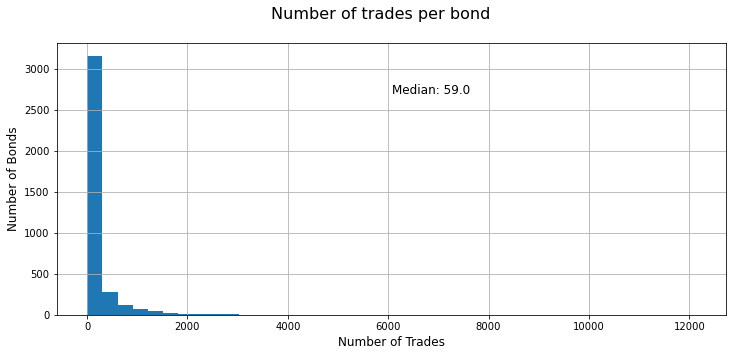

In [4]:
def plot_trade_count(df):
    counts = df.groupby('bond_id').count()["trade_price"]
    ax = counts.hist(bins=40, figsize=(12,5))
    plt.suptitle("Number of trades per bond", fontsize=16)
    plt.xlabel("Number of Trades", fontsize=12)
    plt.ylabel("Number of Bonds", fontsize=12)
    ax.text(0.5, 0.85, f'Median: {counts.median()}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
plot_trade_count(train_data)

The histogram shows that the majority of bonds trade less than 60 times in the training set, but some very liquid bonds trade up to 12,000 times. The plot below compares the most liquid bond, 6968, with one of the least, 29050. Our model must be versatile enough to encompass both.

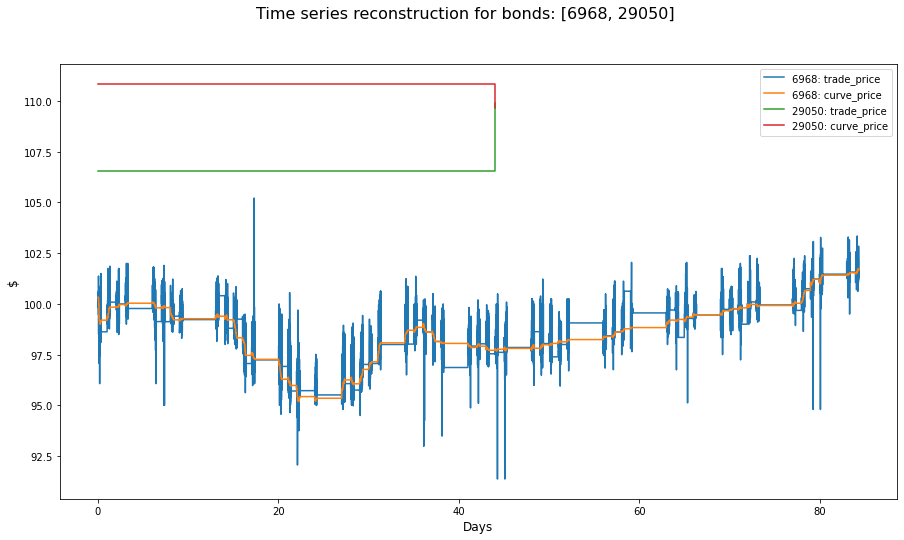

bond_id=6968 traded 12130 times with an average time between trades of 0.17 hours
bond_id=29050 traded 2 times with an average time between trades of 528.52 hours



In [5]:
def plot_time_series(train_data, bond_ids):
    
    fig, ax = plt.subplots(figsize=(15,8))
    print_txt = ""
    legend_names = []
    
    for bond_id in bond_ids:
        this_data = train_data[train_data["bond_id"] == bond_id]
        this_data = this_data[["trade_price", "curve_based_price", "received_time_diff_last1", "trade_price_last1", "curve_based_price_last1"]]
        first_trade = pd.DataFrame({"trade_price": this_data["trade_price_last1"].iloc[0], "curve_based_price": this_data["curve_based_price_last1"].iloc[0], "received_time_diff_last1": 0}, index=[0])
        all_data = pd.concat([first_trade, this_data])
        all_data["time_days"] =  all_data["received_time_diff_last1"].cumsum()/(60*60*24)
        av_intertrade_hours = all_data["received_time_diff_last1"].mean()/(60*60)
        all_data = all_data.set_index("time_days")
        
        all_data[["trade_price", "curve_based_price"]].plot(drawstyle = "steps-post", ax=ax)
        legend_names += [f'{bond_id}: trade_price', f'{bond_id}: curve_price']
        print_txt += f'bond_id={bond_id} traded {len(all_data)} times with an average time between trades of {av_intertrade_hours:.2f} hours\n'
    
    ax.legend(legend_names)
    plt.suptitle(f'Time series reconstruction for bonds: {bond_ids}', fontsize=16)
    plt.xlabel("Days", fontsize=12)
    plt.ylabel("$", fontsize=12)
    plt.show()
    print(print_txt)

plot_time_series(train_data, bond_ids=[6968, 29050])

To force participants to focus on predicting the many fewer trades of the less liquid bonds as much as the more liquid ones, the organisers introduce a weight for each row proportional to $\sqrt{\text{received_time_diff_last1}+ 1}$. This weight is larger for less frequently traded bonds. The selected evaluation criteria was then the Weighted-Mean Absolute Error (WMAE):

$$\text{WMAE} = \frac{\sum{w|y_T - y_P|}}{\sum{w}}$$

where $y_T$ are the true traded prices and $y_P$ the predicted prices.

The overlapping rows in the training set contain a lot of redundant information. To make the training set resemble the test set more closely, for each bond we select every 11th row to remove the overlapping prices. We also randomly select one of the first 10 rows to ensure that we keep some NaN data. If a bond trades less than 10 times we select the latest row, containing the most price information. This ensures that we keep the less liquid, but highly weighted, bonds.

The table below shows that this methodology maintains the weight distribution whilst removing the redundant rows. Our training data is now a tenth of its previous size, meaning that we can also experiment with models more quickly. 

In [6]:
def save_filtered_train_data(train_data):
    
    all_bond_data = []

    for bond_id in train_data['bond_id'].unique():
        this_data = train_data[train_data["bond_id"] == bond_id]
        if len(this_data) >= 10:
            nan_row = this_data.iloc[:9].sample(random_state=SEED)
            no_overlap_data = this_data.iloc[9::11, :]
            all_bond_data += [nan_row, no_overlap_data]
        else:
            no_overlap_data = this_data.iloc[[-1]]
            all_bond_data += [no_overlap_data]

    new_train_data = pd.concat(all_bond_data)
    new_train_data.to_csv("data/filtered_train.csv")
    
# save_filtered_train_data(train_data)

In [5]:
filtered_train_data = load_data("filtered_train")

In [6]:
def compare_weight_dists(name_to_data: map):
        
    data_array = []
    summaries = []
    
    for name, data in name_to_data.items():
        label = name + "_weight"
        data_array += [pd.melt(data[["weight"]].rename(columns={"weight": label}))]
        summary = pd.DataFrame(data["weight"].describe()).transpose().set_index(pd.Index([label]))
        summaries += [summary]
            
    pd.concat(data_array).boxplot(showfliers=False, figsize=(10,5), column="value", by="variable")
    plt.ylabel("$\it{weight}$", fontsize=12)
    plt.xlabel("")
    plt.suptitle('Comparing $\it{weight}$ distribution for datasets: ' + f'{list(name_to_data.keys())}', fontsize=16)
    plt.title("")
    plt.show()
    display(pd.concat(summaries))

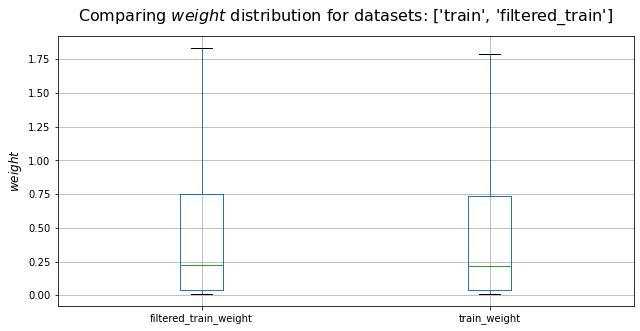

,count,mean,std,min,25%,50%,75%,max
train_weight,762678.0,0.983026,2.164972,0.012991,0.036745,0.220471,0.736710,42.896223
filtered_train_weight,71740.0,1.032470,2.278252,0.012991,0.036745,0.223134,0.755206,42.896223


In [7]:
compare_weight_dists({"train": train_data, "filtered_train": filtered_train_data})

In [8]:
def save_fit_val_data(filtered_train_data):
    
    fit_data, eval_data = train_test_split(filtered_train_data, train_size=0.7, random_state=SEED, shuffle=True)
    fit_data.to_csv("data/fit.csv")
    eval_data.to_csv("data/eval.csv")
    
# save_fit_val_data(filtered_train_data)

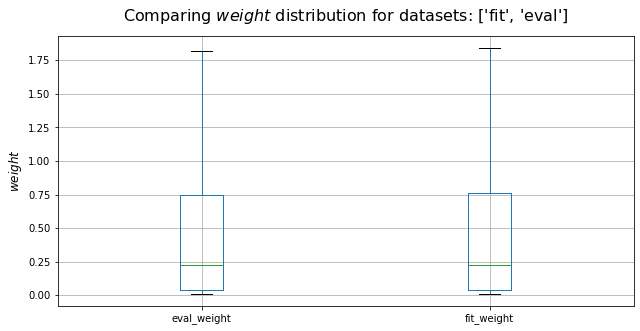

,count,mean,std,min,25%,50%,75%,max
fit_weight,50218.0,1.030593,2.275066,0.012991,0.036745,0.223512,0.758412,42.896223
eval_weight,21522.0,1.036852,2.285716,0.012991,0.036745,0.222377,0.749964,33.715091


In [9]:
fit_data = load_data("fit")
eval_data = load_data("eval")
compare_weight_dists({"fit": fit_data, "eval": eval_data})

Finally, we split the filtered training data into 70-30 fit and evaluation sets. Again, it can be shown that the weight distribution is unchanged across the two sets.

## Exploratory Analysis <a id="eda"></a>


### When is *curve_based_price* a good predictor?

Let's first look at how good the naive predictor *curve_based_price* is. The plots below show MAE and WMAE as a function of binned *received_time_diff_last1*.

Looking first at MAE: it performs worse when a bond hasn't traded for a long time, where the top bin extends up to 128 days. This corresponds to the most illiquid bonds. It performs best at around 30 minutes: a bond is liquid enough to have a meaningful fair price but there has been sufficient time since the previous trade for idiosyncratic microstructure effects to dissipate. Whereas WMAE, which weights trades with larger *received_time_diff_last1* more highly, performs worse as time increases as you might expect.

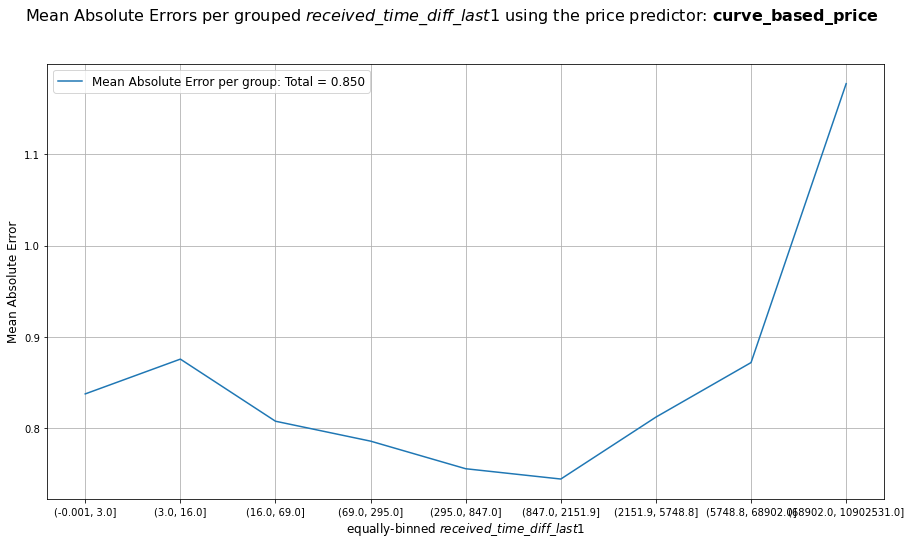

In [12]:
def compute_abs_error(df, normalised=True):
    
    divisor = len(df) if normalised else 1
    return (df["trade_price_predicted"] - df["trade_price"]).abs() / divisor

def compute_w_abs_error(df, normalised=True):
    
    divisor = df["weight"].sum() if normalised else 1
    return (df["trade_price_predicted"] - df["trade_price"]).abs()*df["weight"] / divisor

def plot_errors_by_feature(df, predictor: str, feature: str, is_continuous: bool = True, bins=10, 
                           plot_wmae: bool=True):
    
    # Cannot plot the actual contribution to MAE / WMAE per group as groups could have different
    # number of data points - this would produce misleading plots.
    # Note, this is only true for a discrete feature, as we equally bin continuous features below.
    
    # To make sure plots aren't misleading:
    
    # MAE: plot the MAE per bin
    
    # WMAE: if we simply plot the WMAE per bin the weighting effect (i.e. some bins might have more short-term trades)
    #       will be normalised out. So we plot the averaged raw weighted error per bin, then rescale
    #       so the numbers are comparable to MAE per bin
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    df_copy = df.copy()
    df_copy["trade_price_predicted"] = df_copy[predictor]
    df_copy["raw_abs_error"] = compute_abs_error(df_copy, normalised=False)
    df_copy["raw_w_abs_error"] = compute_w_abs_error(df_copy, normalised=False)
    
    if is_continuous:
        feature_binned = feature + "_bin"
        df_copy[feature_binned] = pd.qcut(df_copy[feature], bins, duplicates = 'drop')
        groupby_feature = feature_binned
        
        x_label_prefix = "equally-binned "
        
    else:
        groupby_feature = feature
        x_label_prefix = ""
    
    groupby = df_copy.groupby(groupby_feature)
    mean_abs_error_by_feature = groupby["raw_abs_error"].mean()        
    mean_w_abs_error_by_feature = groupby["raw_w_abs_error"].mean() * (len(df_copy)/df_copy["weight"].sum())
        
    mean_abs_error_by_feature.plot(ax=ax)
    
    if plot_wmae:        
        mean_w_abs_error_by_feature.plot(ax=ax)
        
    xticks = np.arange(len(mean_abs_error_by_feature.index)) if is_continuous else mean_abs_error_by_feature.index
    plt.xticks(xticks, labels=mean_abs_error_by_feature.index)
    
    abs_error_total = df_copy["raw_abs_error"].mean()
    w_abs_error_total = df_copy["raw_w_abs_error"].sum() / df_copy["weight"].sum()
    
    feature_str = "$\it{" + feature.replace("_", "\_") + "}$"
    predictor_str = r"$\bf{" + predictor.replace("_", "\_") + "}$"
    
    title = f"Mean Absolute Errors per grouped {feature_str} using the price predictor: {predictor_str}"
    plt.suptitle(title, fontsize=16)
    plt.xlabel(x_label_prefix + feature_str, fontsize=12)
    plt.ylabel("Mean Absolute Error", fontsize=12)
    plt.legend([f"Mean Absolute Error per group: Total = {abs_error_total:.3f}", 
                f"Scaled Mean Weighted Absolute Error per group: Total = {w_abs_error_total.sum():.3f}"], fontsize=12)
    plt.grid()
    plt.show()
    
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="received_time_diff_last1", plot_wmae=False)

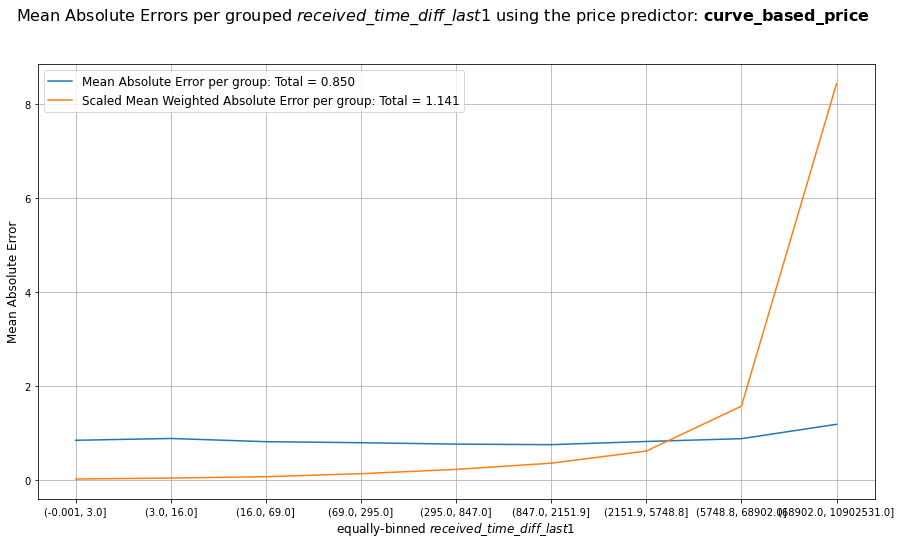

In [21]:
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="received_time_diff_last1")

### When is *trade_price_last1* a good predictor?

As one might expect, the error for *trade_price_last1* is monotonically increasing: as more time passes the previous trade carries less information. Its increased performance at shorter time scales means that its MAE is around 25% better than simply using *curve_based_price*. However, its WMAE is almost exactly the same due to its slightly worse long-time predictive power.

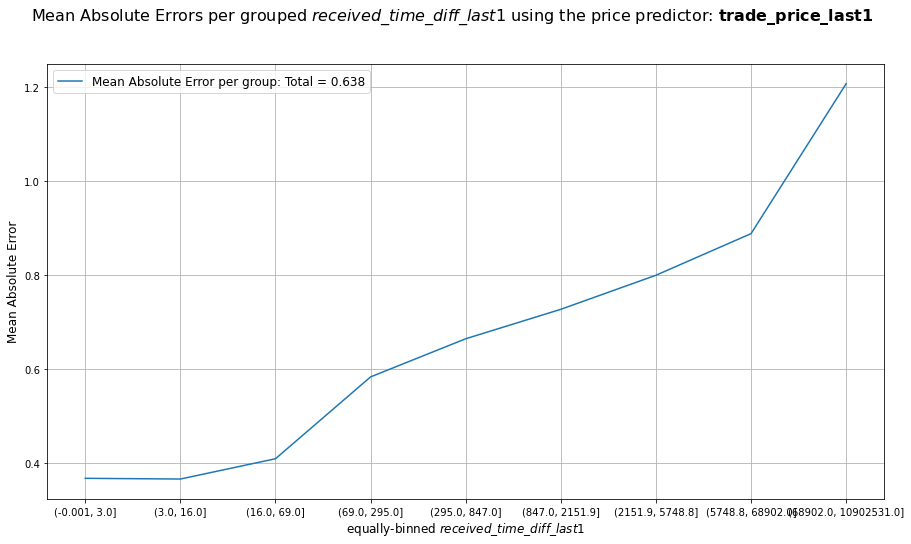

In [14]:
plot_errors_by_feature(fit_data, predictor="trade_price_last1", feature="received_time_diff_last1", plot_wmae=False)

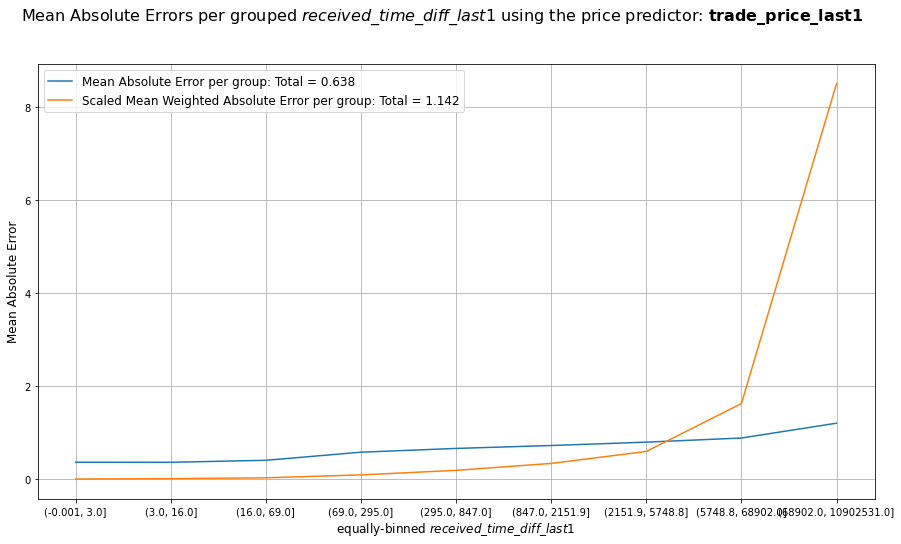

In [15]:
plot_errors_by_feature(fit_data, predictor="trade_price_last1", feature="received_time_diff_last1")

### What effect does *trade_type* have?

In [16]:
def compare_dist_by_discrete_feature(df, by_feature: str, predictor: str="", feature: str=""):
    
    df_copy = df.copy()
    
    if predictor != "":
        feature = predictor + " - " "trade_price"
        df_copy[feature] = df_copy[predictor] - df_copy["trade_price"]
    
    df_copy.boxplot(column=feature, by=by_feature, figsize=(10,5), showfliers=False)
    
    feature_str = "$\it{" + feature.replace("_", "\_") + "}$"
    by_feature_str = "$\it{" + by_feature.replace("_", "\_") + "}$"
    plt.suptitle(f"Comparing [{feature_str}] distribution grouped by: " + by_feature_str, fontsize=16)
    plt.title("")
    plt.xlabel(by_feature_str, fontsize=12)
    plt.ylabel(feature_str, fontsize=12)
    plt.show()
    
    display(df_copy.groupby(by_feature)[feature].describe())

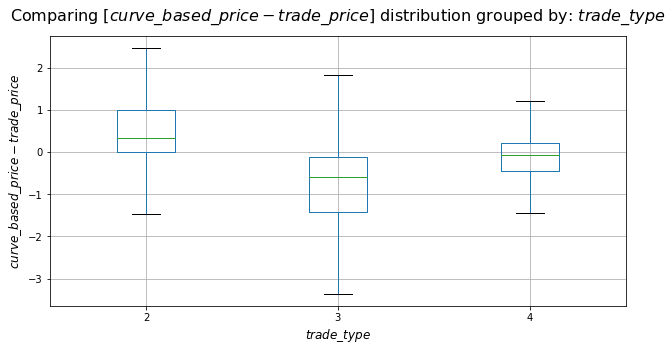

,count,mean,std,min,25%,50%,75%,max
trade_type,,,,,,,,
2,10166.0,0.599941,1.374995,-10.321146,0.012860,0.336328,0.996954,26.152510
3,18115.0,-0.810434,1.351350,-10.972354,-1.412179,-0.581505,-0.115262,19.473037
4,21937.0,-0.098185,1.116190,-8.648361,-0.439914,-0.069636,0.225695,13.872320


In [17]:
compare_dist_by_discrete_feature(fit_data, predictor="curve_based_price", by_feature="trade_type")

As one might expect, *trade_type=2* (customer SELL) on-average has a *trade_price* that is less than the fair estimate: *curve_based_price*. Whilst *trade_type=3* (customer BUY) is the other way around. For *trade_type=4* (inter-dealer trade) the side is not reported so the positive and negative half-spreads cancel out on-average.

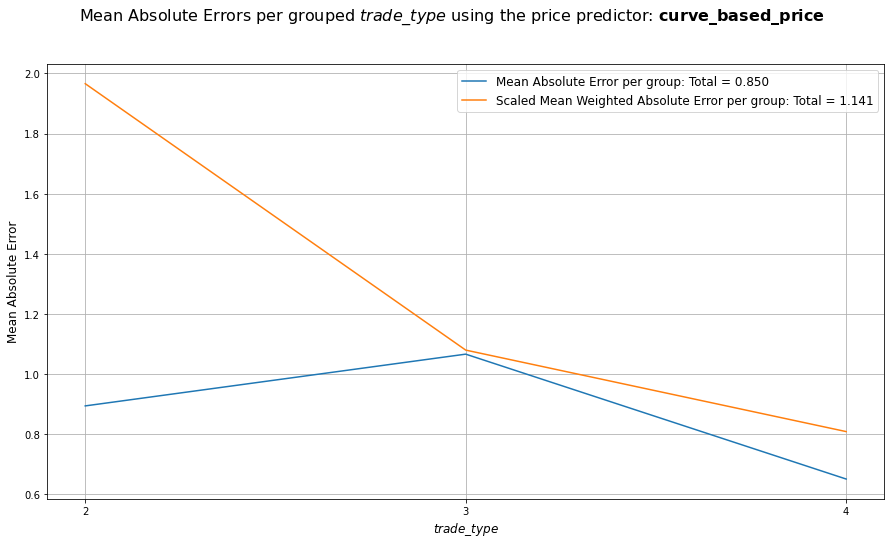

In [18]:
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="trade_type", is_continuous=False)

The MAE shows that dealers typically charge clients a larger half-spread to BUY a bond than they do to SELL one. 
This is because a dealer must borrow a specific bond to satisfy a client BUY order; to do this they must do a *specific reverse-repo* trade in the Credit Repo market to cover their short position. This *Specifics* or *Specials* Repo market is facilitated by traders who are managing the supply and demand of particular issues whilst focussing on their relative-value.

However, for a dealer to borrow the cash required for a client SELL order they need to do a *general repo* trade in which the bond they lend to the Repo market as collateral can be one of a basket of issues. These baskets are typically grouped by rating/maturity (e.g. US IG with remaining maturity < 20 years). The dealer can lend any issue within the basket and be charged the same repo rate. This *General Collateral (GC)* Repo market is driven much more by the supply and demand for cash rather than particular issues, and hence is highly correlated to money-market interest rates.

The specific repo rate is usually wider than the GC repo rate and so dealers need to pass on these extra balance sheet costs to their clients. Inter-dealer spreads are tighter than client spreads as one might expect.

### What effect does *is_callable* have?

As callable bonds can be redeemed and paid-off by issuers at any point, investors demand to be compensated for the potential lack of income with higher coupons.

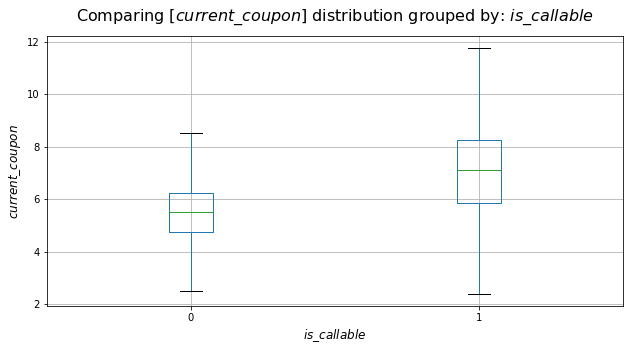

,count,mean,std,min,25%,50%,75%,max
is_callable,,,,,,,,
0,44515.0,5.387111,1.584728,0.000,4.75,5.500,6.25,13.0
1,5703.0,7.210777,1.946089,0.548,5.85,7.125,8.25,13.5


In [19]:
compare_dist_by_discrete_feature(fit_data, feature="current_coupon", by_feature="is_callable")

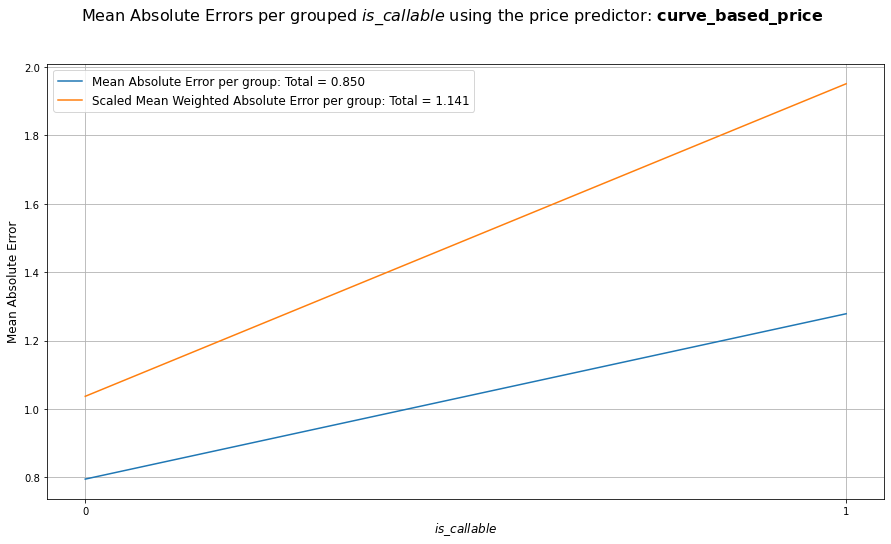

In [20]:
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="is_callable", is_continuous=False)

It appears that *curve_based_price* is less accurate for callable bonds. One might expect these bespoke bonds to trade more idiosyncratically with larger spreads on average.

### What effect does *trade_size* have?

The histogram below shows that half of all trades are small and below \\$25,000. Most trade sizes are multiples of 10, those that aren't are called *oddlots*. The plot below shows that almost all oddlots are either \\$1,000,001 or \\$5,000,001. Note that these are probably placeholders and signify that the trade was actually much larger than this. Recall that for sufficiently large trades (\\$5m for IG and \\$1m for HY) the size does not need to be reported to TRACE. This may prove to be a useful feature later.

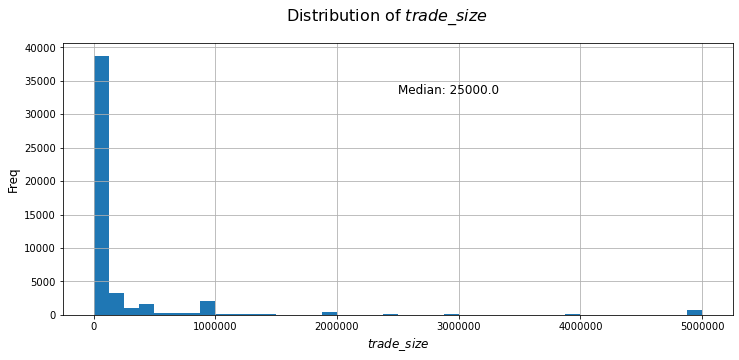

In [21]:
def plot_hist(df, feature: str):
    ax = df[feature].hist(bins=40, figsize=(12,5))
    
    feature_str = "$\it{" + feature.replace("_", "\_") + "}$"
    plt.suptitle(f"Distribution of {feature_str}", fontsize=16)
    plt.xlabel(feature_str, fontsize=12)
    plt.ylabel("Freq", fontsize=12)
    ax.text(0.5, 0.85, f'Median: {df[feature].median()}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.ticklabel_format(style='plain')
    
plot_hist(fit_data, feature="trade_size")

In [22]:
def plot_oddlots_hist(df):
    
    df_copy = df.copy()
    trade_size_label = "trade_size"
    df_copy["is_oddlot"] = df[trade_size_label].apply(lambda x: x!=round(x/10)*10)
    oddlots = df_copy[df_copy["is_oddlot"]]
    
    ax = (100*oddlots.groupby(trade_size_label).count()["bond_id"] / len(df_copy)).plot.bar(figsize=(12,5))
    trade_size_str = "$\it{" + trade_size_label.replace("_", "\_") + "}$"
    plt.suptitle(f"Distribution of oddlot {trade_size_str}", fontsize=16)
    plt.xlabel(trade_size_str, fontsize=12)
    plt.ylabel("% of entire population", fontsize=12)

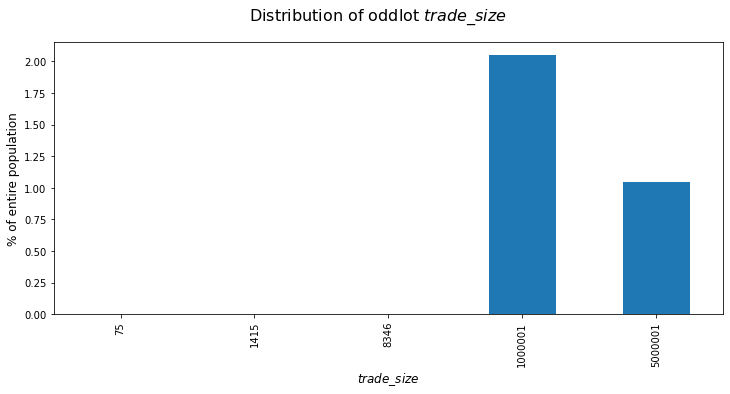

In [23]:
plot_oddlots_hist(fit_data)

The plot below suggets that *curve_based_price* is better at predicting large trades. This could maybe be explained by smaller bonds trading more idiosyncratically away from their fair price. However, once the lower frequency of these larger trades is accounted for, the WMAE is pretty constant across *trade_size*.

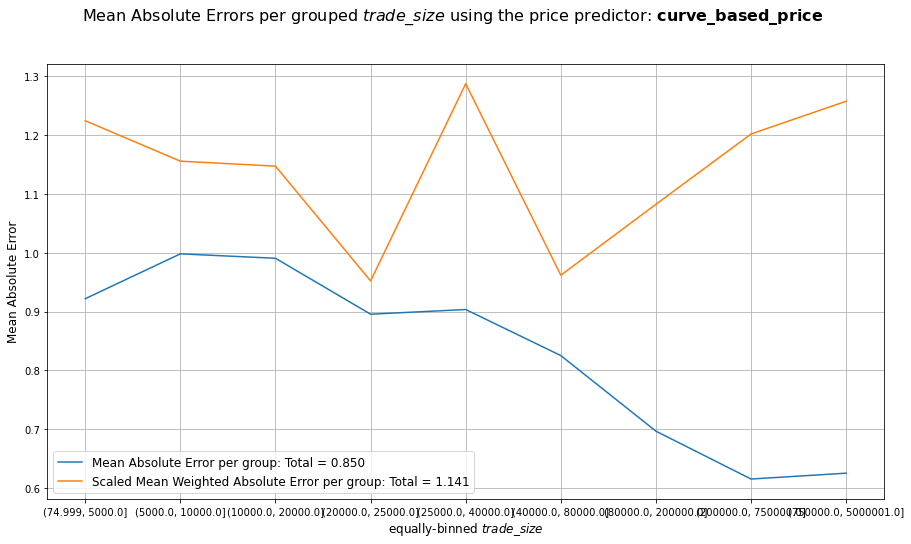

In [24]:
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="trade_size")

### What effect does *time_to_maturity* have?

The plot below shows that longer maturity bonds trade less frequently and are more illiquid, as one might expect.

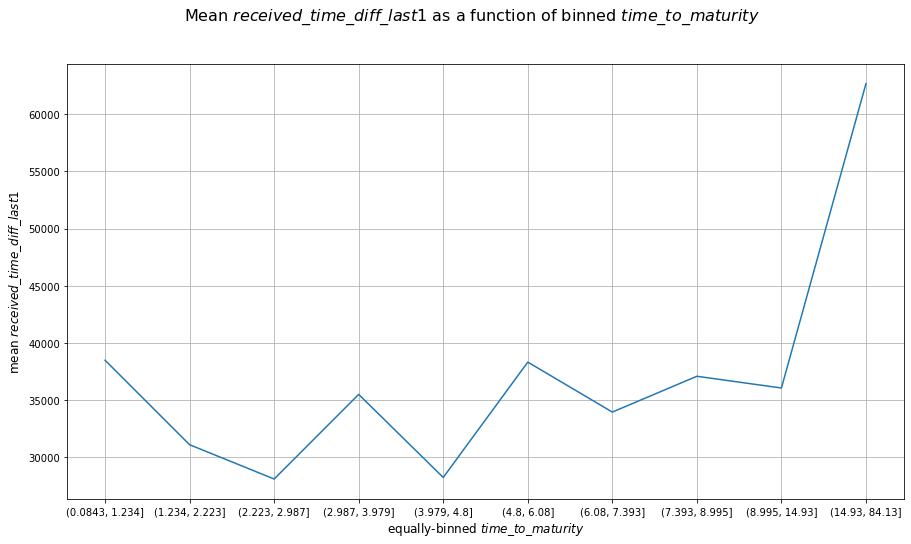

In [25]:
def plot_binned_scatter(df, x: str, y: str, bins=10):
    
    df_copy = df.copy()
    
    x_binned = x + "_bin"
    df_copy[x_binned] = pd.qcut(df_copy[x], bins, duplicates = 'drop')
    mean_y_by_binned_x = df_copy.groupby(x_binned)[y].mean()
    ax = mean_y_by_binned_x.plot(figsize=(15,8))
    plt.xticks(np.arange(len(mean_y_by_binned_x.index)), mean_y_by_binned_x.index)
    
    x_str = "$\it{" + x.replace("_", "\_") + "}$"
    y_str = "$\it{" + y.replace("_", "\_") + "}$"
    plt.suptitle(f"Mean {y_str} as a function of binned {x_str}", fontsize=16)
    plt.xlabel(f"equally-binned {x_str}", fontsize=12)
    plt.ylabel(f"mean {y_str}", fontsize=12)
    plt.grid()

plot_binned_scatter(fit_data, x="time_to_maturity", y="received_time_diff_last1")

It appears that *curve_based_price* becomes a progressively worse predictor as the maturity of the bond increases. 
The plot above hints that this is probably caused by the confounding *received_time_diff_last1* feature, since we already know that *curve_based_price* is worse at these longer time scales.

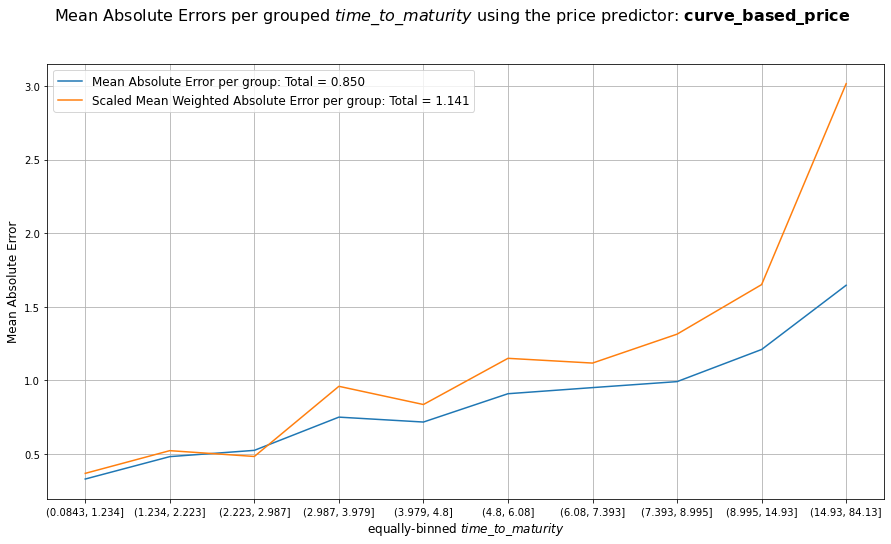

In [26]:
plot_errors_by_feature(fit_data, predictor="curve_based_price", feature="time_to_maturity")

## Building a model <a id="building_model"></a>

### Pre-processing <a id="pre_processing"></a>

Some models require all input features to be numerical. To achieve this we will encode *trade_type* = {2,3,4} into three numerical binary features: *is_c_SELL*, *is_c_BUY* and *is_dealer*.

We also need to deal with the NaN entries in the lagged trade data, either because no previous trade exists or simply because the data is corrupted. For each of the lags, if any of the data is NaN then all the data at that lag is set to -999. This will also be indicated by a binary variable *isnan_last{1-10}* for each lag.

In [22]:
def save_clean_data(name_to_data: map):
    
    lagged_cols = ["trade_price_last", "trade_size_last", "trade_type_last", 
                   "received_time_diff_last", "curve_based_price_last", "trade_minus_curve_price_last"]
    
    for name, data in name_to_data.items():
        df_copy = data.copy()
        df_copy["is_c_SELL"] = (df_copy["trade_type"] == 2).apply(int)
        df_copy["is_c_BUY"] = (df_copy["trade_type"] == 3).apply(int)
        df_copy["is_dealer"] = (df_copy["trade_type"] == 4).apply(int)
        df_copy["is_large_trade"] = np.isin(df_copy["trade_size"], [1000001, 5000001])
        df_copy["is_large_trade"] = df_copy["is_large_trade"].apply(int)
        
        for i in range(1,11):
            
            df_copy[f"trade_minus_curve_price_last{i}"] = df_copy[f"trade_price_last{i}"] - df_copy[f"curve_based_price_last{i}"]
            
            df_copy[f"is_c_SELL_last{i}"] = (df_copy[f"trade_type_last{i}"] == 2).apply(int)
            df_copy[f"is_c_BUY_last{i}"] = (df_copy[f"trade_type_last{i}"] == 3).apply(int)
            df_copy[f"is_dealer_last{i}"] = (df_copy[f"trade_type_last{i}"] == 4).apply(int)
            
            all_lagged_cols = [f"{x}{i}" for x in lagged_cols]
            
            isna = df_copy[all_lagged_cols].applymap(pd.isna).any(axis="columns")
            df_copy.loc[isna, all_lagged_cols] = MISSING_VAL
            df_copy[f"isnan_last{i}"] = isna.apply(int)
            
        df_copy.to_csv(f"data/{name}_clean.csv")
        
# save_clean_data({"fit": fit_data, "eval": eval_data})

In [10]:
fit_clean_data = load_data("fit_clean")
eval_clean_data = load_data("eval_clean")

### Baseline Model <a id="baseline"></a>

Here we intuitively select *curve_based_price* as our baseline model.

In [25]:
def score_baseline(name_to_data: map):
    
    for name, data in name_to_data.items():
        df_copy = data.copy()
        df_copy["trade_price_predicted"] = df_copy["curve_based_price"]
        score = compute_w_abs_error(df_copy).sum()
        
        print(f"{name}: WMAE = {score:.3f}")

score_baseline({"fit_clean": fit_clean_data, "eval_clean": eval_clean_data})

fit_clean: WMAE = 1.141
eval_clean: WMAE = 1.169


### Problem Formulation <a id="formulation"></a>

We could simply predict *trade_price* directly, though it could be that price changes are a more robust variable to predict. We will explore different formulations of the prediction problem below. At this stage we will do no feature selection/engineering or hyperparameter tuning. We're simply trying to deduce which formulation of the problem is most effective.

* **Weighted Linear Least Squares Regression**: despite the problem optimising for absolute-error rather than squared-error, we will try Least Squares regression as a baseline. Note that unregularised LS regression requires that the features are all linearly independent, otherwise the covariance matrix will not be invertible. One-hot encoding introduces a redundant feature that breaks this assumption, so instead we will use *dummy* encoding that drops one of the binary columns. Although the model is technically invariant to feature normalisation, we perform this step anyway so that the coefficients are more interpretable.


* **Random Forest Regression**: this ensemble method aims to minimise overfitting by averaging across lots of weakly learned trees. It uses the correct WMAE objective function. Hyperparameters are selected to speed-up training time. Here we use the original one-hot encoding. Trees are also indifferent to feature normalisation, as they only care about the order of the data, so we skip this step.


* **Gradient Boosted Regression Trees**: this ensemble method aims to minimise in-sample error/bias by iteratively training weakly-learned trees on the errors of previous trees, though it also employs some techniques to reduce overfitting. It is equivalent to gradient-descent in function space and so its error needs to be twice-differentiable. MAE doesn't satisfy this, so instead we use the Pseudo-Huber loss function to approximate it. During fitting we also provide the *evaluation* data; the model will optimise on the *fit* data until the *evaluation* MAE score hasn't improved in *early_stopping_rounds* epochs. Here we use the original one-hot encoding, but remove the *isnan_last{1-10}* binary features as the model has an in-built way of handling missing values.


* **Feed-Forward Neural Network**: we train a fully-connected neural network with dropout and one hidden layer. It uses stochastic gradient-descent to minimise WMAE at the output layer and back-propagation to update the weights in the previous layers. As with LS regression, neural networks are sensitive to linearly dependent features, so we use the same dummy encoding. Their numerical schemes are also known to be sensitive to the scale of input features, so we add a standard rescaling step. The dropout layer randomly zeros-out some input features each epoch at a pre-determined rate; this acts to regularise the model and prevent overfitting.

In [26]:
def get_discrete_features(encoding: str=None, include_isnan: bool=True, max_lag:int=10):
    
    if encoding not in [None, "one-hot", "dummy"]:
        raise Exception("Not a valid encoding")
    
    this_trade_cols = ["is_callable"]
    lagged_cols_template = []
    
    if include_isnan:
        lagged_cols_template += ["isnan_last"]

    if encoding == None:
        this_trade_cols += ["trade_type"]
        lagged_cols_template += ["trade_type_last"]
    elif encoding == "dummy":
        this_trade_cols += ["is_c_SELL", "is_c_BUY"]
        lagged_cols_template += ["is_c_SELL_last", "is_c_BUY_last"]
    elif encoding == "one-hot":
        this_trade_cols += ["is_c_SELL", "is_c_BUY", "is_dealer"]
        lagged_cols_template += ["is_c_SELL_last", "is_c_BUY_last", "is_dealer_last"]
        
    lagged_cols = [f"{x}{i}" for x in lagged_cols_template for i in range(1,max_lag+1)]
    return this_trade_cols + lagged_cols

def get_cont_features(max_lag:int=10, exclude: list=[]):
    
    this_trade_cols = ["trade_size", "current_coupon", "time_to_maturity", "reporting_delay", "curve_based_price"]
    lagged_cols_template = ["trade_price_last", "curve_based_price_last", "received_time_diff_last", "trade_size_last"]
    
    lagged_cols = [f"{x}{i}" for x in lagged_cols_template for i in range(1,max_lag+1)]
    cols = this_trade_cols + lagged_cols
    
    for feature in exclude:
        if feature in cols:
            cols.remove(feature)
            
    return cols

In [27]:
class pca_wrapper:
    
    def __init__(self, num_factors=None, max_lag=10, holdout_cols=[], baseline=None):
        self.num_factors = num_factors
        self.factor_cols = [f"factor_{i}" for i in range(self.num_factors)]
        # always compute all factors, just use num_factors for .get_decomp() or .transform()
        self.pca = PCA()
        self.holdout_cols = holdout_cols
        
        if baseline in self.holdout_cols:
            raise Exception("Do not include baseline in holdout_cols, it will automatically be left out of the PCA training")
        
        exclude_cols = self.holdout_cols if baseline is None else self.holdout_cols + [baseline]
        self.pca_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols)
        print(f"PCA created with {len(self.pca_features)} continous features")
        self.scaler = StandardScaler()
        
    def fit(self, df):
        standard_df = pd.DataFrame(self.scaler.fit_transform(df[self.pca_features]), 
                                   columns=self.pca_features, index=df.index)        
        self.pca.fit(standard_df)
        
    def get_explained_var(self):
        return self.pca.explained_variance_ratio_
    
    def get_decomp(self):
        df = pd.DataFrame(self.pca.components_, columns=self.pca_features).transpose()[[i for i in range(self.num_factors)]]
        return df.rename(columns = {i : self.factor_cols[i] for i in range(self.num_factors)})
    
    def transform(self, df):
        standard_df = pd.DataFrame(self.scaler.transform(df[self.pca_features]), 
                                   columns=self.pca_features, index=df.index)
        
        transformed_df = pd.DataFrame(self.pca.transform(standard_df), index=standard_df.index)[[i for i in range(self.num_factors)]]
        return transformed_df.rename(columns = {i : self.factor_cols[i] for i in range(self.num_factors)})

In [28]:
class RegressionModelBase(ABC):
    
    def __init__(self, baseline:str, max_lag:int, pca_args:dict, discrete_feat:list, cont_feat:list):
        self.predict_delta_price = False if baseline is None else True
        self.baseline = baseline
        self.predictee = f"trade_price - {self.baseline}" if self.predict_delta_price else "trade_price"
        # remove baseline from features as its information will be encoded in the new target
        self.exclude_cols = [self.baseline] if self.predict_delta_price else []
        
        self.pca_decomp = False if pca_args is None else True
        self.pca = pca_wrapper(baseline=self.baseline, max_lag=max_lag, **pca_args) if self.pca_decomp else None

        self.discrete_features = self.get_discrete_features(max_lag) if len(discrete_feat) == 0 else discrete_feat
        self.cont_features = self.get_cont_features(max_lag) if len(cont_feat) == 0 else cont_feat
        self.all_features = self.discrete_features + self.cont_features
        output = f"Model created with {len(self.all_features)} features: " + \
                 f"{len(self.discrete_features)} discrete, {len(self.cont_features)} continuous"
        output += f" [{self.pca.num_factors} PCA]" if self.pca_decomp else ""
        output += f". max_lag={max_lag}"
        print(output)
        print(f"Predicting: {self.predictee} \n")
        
    def get_cont_features(self, max_lag):
        if self.pca_decomp:
            # everything except pca.holdout_cols has been transformed into factor_cols
            return self.pca.factor_cols + self.pca.holdout_cols
        else:
            return get_cont_features(max_lag=max_lag, exclude=self.exclude_cols)
    
    @abstractmethod
    def get_discrete_features(self, max_lag:int):
        pass
    
    def _pca_fit_transform(self, fit_df):
        if self.pca_decomp:
            print("Running PCA fit pipeline")
            self.pca.fit(fit_df)
            return self._pca_transform(fit_df)                        
        else:
            return fit_df.copy()
        
    @abstractmethod
    def fit(self, fit_df, eval_df=None):
        pass
    
    def _pca_transform(self, df):
        if self.pca_decomp:
            factors_df = self.pca.transform(df)
            return pd.concat([factors_df, df], axis=1)
        else:
            return df.copy()
    
    @abstractmethod
    def _predict(self, df):
        pass
    
    def score(self, df):
        transformed_df = self._pca_transform(df) if self.pca_decomp else df.copy()
        transformed_df[f"{self.predictee}_predicted"] = self._predict(transformed_df)
        
        if self.predict_delta_price:
            transformed_df["trade_price_predicted"] = transformed_df[f"{self.predictee}_predicted"] + transformed_df[self.baseline]
        
        return compute_w_abs_error(transformed_df).sum()

In [29]:
class LinearReg(RegressionModelBase):
    
    default_params = {"fit_intercept": True,
                      "normalize": True}
    
    other_params = {"predictee_clip_quantile": 0,} # no clipping by default
    
    def __init__(self, baseline:str=None, max_lag:int=10, pca_args:dict=None, 
                 discrete_feat:list=[], cont_feat:list=[], **kwargs):
        super().__init__(baseline, max_lag, pca_args, discrete_feat, cont_feat)
        self.model_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in LinearReg.default_params.items()}
        self.other_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in LinearReg.other_params.items()}
        # Use linear_model.SGDRegressor to minimise MAE?
        # https://stackoverflow.com/questions/50392783/training-linear-models-with-mae-using-sklearn-in-python
        self.model = linear_model.LinearRegression(**self.model_params)
        
    def get_discrete_features(self, max_lag:int):
        return get_discrete_features(encoding="dummy", max_lag=max_lag)
    
    def fit(self, fit_df, eval_df=None):
        start = time.time()
        
        trans_fit_df = super()._pca_fit_transform(fit_df)
                
        if self.predict_delta_price:
            trans_fit_df[self.predictee] = trans_fit_df["trade_price"] - trans_fit_df[self.baseline]
            
        clip_quantile = self.other_params["predictee_clip_quantile"]
        trans_fit_df[self.predictee] = winsorize(trans_fit_df[self.predictee], limits=(clip_quantile, clip_quantile))
        
        print("Running Model fit pipeline")
        self.model.fit(trans_fit_df[self.all_features], trans_fit_df[self.predictee],
                       sample_weight=trans_fit_df["weight"])
        
        print(f"Fitting took {time.time() - start:.2f} seconds")
    
    def _predict(self, df):
        return self.model.predict(df[self.all_features])
    
    def plot_feature_importance(self):
        
        feat_importance = pd.DataFrame(self.model.coef_, 
                                       index=self.all_features, columns=["importance"])
        feat_importance["importance"] = feat_importance["importance"].abs()
        feat_importance = feat_importance.sort_values("importance", ascending=False)

        ax = feat_importance["importance"].plot.bar(figsize=(20,10))
        ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=75,
                horizontalalignment='right'
        );

In [30]:
class Lasso(LinearReg):
    
    default_params = {"random_state": SEED,
                      "fit_intercept": True,
                      "normalize": True,
                      "alpha": 1e-4, # L1 regularisation weighting
                      "max_iter": 5000}
    
    other_params = {"predictee_clip_quantile": 0,} # no clipping by default
    
    def __init__(self, baseline:str=None, max_lag:int=10, pca_args:dict=None, 
                 discrete_feat:list=[], cont_feat:list=[], **kwargs):
        super().__init__(baseline, max_lag, pca_args, discrete_feat, cont_feat)
        self.model_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in Lasso.default_params.items()}
        self.other_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in Lasso.other_params.items()}
        self.model = linear_model.Lasso(**self.model_params)

In [31]:
class RandomForest(RegressionModelBase):
    
    default_params = {"criterion": "mae",
                      "random_state": SEED,
                      "max_samples": 0.5, # subsample ratio for data for each base tree
                      "max_features": "sqrt", # inspect max sqrt(num_features) features at each split
                      "n_estimators": 50, # number of trees in the forest
                      "max_depth": 4}
    
    other_params = {"predictee_clip_quantile": 0,} # no clipping by default
    
    def __init__(self, baseline:str=None, max_lag:int=10, pca_args:dict=None, 
                 discrete_feat:list=[], cont_feat:list=[], **kwargs):
        super().__init__(baseline, max_lag, pca_args, discrete_feat, cont_feat)
        self.model_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in RandomForest.default_params.items()}
        self.other_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in RandomForest.other_params.items()}
        self.model = ensemble.RandomForestRegressor(**self.model_params)
        
    def get_discrete_features(self, max_lag:int):
        return get_discrete_features(encoding="one-hot", max_lag=max_lag)
    
    def fit(self, fit_df, eval_df=None):
        start = time.time()
        
        trans_fit_df = super()._pca_fit_transform(fit_df)
        
        if self.predict_delta_price:
            trans_fit_df[self.predictee] = trans_fit_df["trade_price"] - trans_fit_df[self.baseline]
            
        clip_quantile = self.other_params["predictee_clip_quantile"]
        trans_fit_df[self.predictee] = winsorize(trans_fit_df[self.predictee], limits=(clip_quantile, clip_quantile))
        
        print("Running Model fit pipeline")
        self.model.fit(trans_fit_df[self.all_features], trans_fit_df[self.predictee], 
                       sample_weight=trans_fit_df["weight"])        
        print(f"Fitting took {time.time() - start:.2f} seconds")
    
    def _predict(self, df):
        return self.model.predict(df[self.all_features])
    
    def plot_feature_importance(self):
                                     
        feat_importance = pd.DataFrame(self.model.feature_importances_, 
                                       index=self.all_features, columns=["importance"])
        feat_importance = feat_importance.sort_values("importance", ascending=False)
                                                      
        ax = feat_importance["importance"].plot.bar(figsize=(20,10))
        ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=75,
                horizontalalignment='right'
        );

In [32]:
class BoostedTrees(RegressionModelBase):
    
    default_params = {"objective": "reg:pseudohubererror",
                      "random_state": SEED,
                      "subsample": 0.5, # subsample ratio for data at each boosting round
                      "colsample_bytree": 1, # subsample ratio for columns at each tree
                      "n_estimators": 200, # number of boosting rounds
                      #"reg_alpha": 0, # L1 regularisation weighting
                      "max_depth": 6,
                      "learning_rate": 0.01,
                      "missing": MISSING_VAL}
    
    other_params = {"eval_metric": "mae",
                    "early_stopping_rounds": 10,
                    "verbose": False,
                    "predictee_clip_quantile": 0,} # no clipping by default
    
    def __init__(self, baseline:str=None, max_lag:int=10, pca_args:dict=None, 
                 discrete_feat:list=[], cont_feat:list=[], **kwargs):
        super().__init__(baseline, max_lag, pca_args, discrete_feat, cont_feat)
        self.model_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in BoostedTrees.default_params.items()}
        self.other_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in BoostedTrees.other_params.items()}
        self.model = xgboost.XGBRegressor(**self.model_params)
        
    def get_discrete_features(self, max_lag:int):
        return get_discrete_features(encoding="one-hot", include_isnan=False, max_lag=max_lag)
    
    def fit(self, fit_df, eval_df=None):
        start = time.time()
        
        trans_fit_df = super()._pca_fit_transform(fit_df)
        trans_eval_df = super()._pca_transform(eval_df)
        
        if self.predict_delta_price:
            trans_fit_df[self.predictee] = trans_fit_df["trade_price"] - trans_fit_df[self.baseline]
            trans_eval_df[self.predictee] = trans_eval_df["trade_price"] - trans_eval_df[self.baseline]
            
        clip_quantile = self.other_params["predictee_clip_quantile"]
        trans_fit_df[self.predictee] = winsorize(trans_fit_df[self.predictee], limits=(clip_quantile, clip_quantile))

        print("Running Model fit pipeline")
        self.model.fit(trans_fit_df[self.all_features], trans_fit_df[self.predictee], 
                       sample_weight=trans_fit_df["weight"],
                       eval_set=[(trans_eval_df[self.all_features], trans_eval_df[self.predictee])],
                       sample_weight_eval_set=[trans_eval_df["weight"]],
                       eval_metric=self.other_params["eval_metric"], verbose=self.other_params["verbose"],
                       early_stopping_rounds=self.other_params["early_stopping_rounds"])
        
        print(f"Fitting took {time.time() - start:.2f} seconds")
        
        if not self.other_params["verbose"]:
            eval_result = self.model.evals_result()["validation_0"][self.other_params["eval_metric"]]
            print(f"Epochs: {len(eval_result)}, eval WMAE: {eval_result[-1]}")
            
    def _predict(self, df):
        return self.model.predict(df[self.all_features])
                                     
    def plot_feature_importance(self):
                                     
        feat_importance = pd.DataFrame(self.model.feature_importances_, 
                                       index=self.all_features, columns=["importance"])
        feat_importance = feat_importance.sort_values("importance", ascending=False)
                                                      
        ax = feat_importance["importance"].plot.bar(figsize=(20,10))
        ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=75,
                horizontalalignment='right'
        );

In [33]:
class NeuralNet(RegressionModelBase):
    
    default_params = {"random_state": SEED,
                      "subsample": 0.5, # subsample ratio for data at each epoch
                      "dropout_rate": 0, # no dropout by default
                      "hidden_nodes": 15,
                      "epochs": 1500,
                      "learning_rate": 0.01,
                      "predictee_clip_quantile": 0, # no clipping by default
                      "verbose": False}
    
    def __init__(self, baseline:str=None, max_lag:int=10, pca_args:dict=None, 
                 discrete_feat:list=[], cont_feat:list=[], **kwargs):
        super().__init__(baseline, max_lag, pca_args, discrete_feat, cont_feat)
        self.model_params = {key : (val if key not in kwargs else kwargs[key]) for key,val in NeuralNet.default_params.items()}
        self.feature_scaler = StandardScaler()
        
        input_layer = Input(shape=(len(self.all_features),))
        seed = self.model_params["random_state"]
        
        dropout_layer = Dropout(self.model_params["dropout_rate"], seed=seed)(input_layer)
        
        hidden_layer = Dense(self.model_params["hidden_nodes"], activation=tf.nn.relu,
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=seed)
                             )(dropout_layer)
        
        # output activation is linear by default
        output_layer = Dense(1, 
                             kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1, seed=seed)
                             )(hidden_layer)
        
        self.model = Model(inputs=input_layer, outputs=output_layer)
        
        self.model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=self.model_params["learning_rate"]))
        
    def get_discrete_features(self, max_lag:int):
        return get_discrete_features(encoding="dummy", max_lag=max_lag)

    def fit(self, fit_df, eval_df=None):
        
        start = time.time()
        
        trans_fit_df = super()._pca_fit_transform(fit_df)
        
        if self.predict_delta_price:
            trans_fit_df[self.predictee] = trans_fit_df["trade_price"] - trans_fit_df[self.baseline]
            
        clip_quantile = self.model_params["predictee_clip_quantile"]
        trans_fit_df[self.predictee] = winsorize(trans_fit_df[self.predictee], limits=(clip_quantile, clip_quantile))

        # normalise the continuous features
        trans_fit_df.loc[:, self.cont_features] = self.feature_scaler.fit_transform(trans_fit_df[self.cont_features])     
        
        batch_size = int(self.model_params["subsample"]*len(trans_fit_df))
        print("Running Model fit pipeline")
        history = self.model.fit(trans_fit_df[self.all_features], trans_fit_df[self.predictee], 
                                 sample_weight=trans_fit_df["weight"], batch_size=batch_size, shuffle=True, 
                                 verbose=self.model_params["verbose"], epochs=self.model_params["epochs"])

        print(f"Fitting took {time.time() - start:.2f} seconds")
        
        if not self.model_params["verbose"]:
            eval_result = history.history["loss"]
            print(f"Epochs: {len(eval_result)}, fit WMAE: {eval_result[-1]}")
    
    def _predict(self, df):
        df_copy = df.copy()
        # normalise the continuous features using the scaling learnt at .fit()
        df_copy.loc[:, self.cont_features] = self.feature_scaler.transform(df_copy[self.cont_features])
        return self.model.predict(df_copy[self.all_features])

#### Predict *trade_price*

Below we will naively attempt to directly predict *trade_price* using different models.

In [138]:
linear_reg = LinearReg()
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 78 features: 33 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.19 seconds
fit_clean: WMAE = 0.872
eval_clean: WMAE = 0.944


In [247]:
lasso = Lasso()
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 78 features: 33 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 1.56 seconds
fit_clean: WMAE = 0.936
eval_clean: WMAE = 0.970


In [159]:
r_forest = RandomForest()
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 89 features: 44 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 500.47 seconds
fit_clean: WMAE = 1.372
eval_clean: WMAE = 1.462


In [148]:
b_tree = BoostedTrees()
b_tree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {b_tree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {b_tree.score(eval_clean_data):.3f}")
del b_tree

Model created with 79 features: 34 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 65.27 seconds
Epochs: 200, eval MAE: 1.400075
fit_clean: WMAE = 1.178
eval_clean: WMAE = 1.400


In [30]:
nn = NeuralNet(hidden_nodes=40, epochs=3000)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 78 features: 33 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 51.06 seconds
Epochs: 3000, fit WMAE: 1.0215896368026733
fit_clean: WMAE = 0.878
eval_clean: WMAE = 1.084


#### Predicting price differences

It makes intuitive sense that most trading dynamics, especially in the short-term, are independent of actual price levels. Instead they are driven more by changes in price. For example, above we have seen that given the *curve_based_price* and the side of the next trade you can quite confidently predict whether the *trade_price* will be above or below this fair value. Forcing the model to predict [*trade_price - curve_based_price*] might yield better results - this is equivalent to learning the charge that market-makers are applying.

In [265]:
linear_reg = LinearReg(baseline="curve_based_price")
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.21 seconds
fit_clean: WMAE = 0.915
eval_clean: WMAE = 0.977


In [151]:
lasso = Lasso(baseline="curve_based_price")
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 1.29 seconds
fit_clean: WMAE = 0.988
eval_clean: WMAE = 1.006


In [160]:
r_forest = RandomForest(baseline="curve_based_price")
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 88 features: 44 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 685.60 seconds
fit_clean: WMAE = 1.052
eval_clean: WMAE = 1.091


In [152]:
b_tree = BoostedTrees(baseline="curve_based_price")
b_tree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {b_tree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {b_tree.score(eval_clean_data):.3f}")
del b_tree

Model created with 78 features: 34 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 68.32 seconds
Epochs: 200, eval MAE: 0.991491
fit_clean: WMAE = 0.819
eval_clean: WMAE = 0.992


In [153]:
nn = NeuralNet(baseline="curve_based_price")
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 17.02 seconds
Epochs: 1500, fit MAE: 0.8512406945228577
fit_clean: WMAE = 0.824
eval_clean: WMAE = 0.923


We will also try fitting with *trade_price_last1* as a baseline.

In [154]:
linear_reg = LinearReg(baseline="trade_price_last1")
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - trade_price_last1 

Running Model fit pipeline
Fitting took 0.13 seconds
fit_clean: WMAE = 1.007
eval_clean: WMAE = 1.095


In [155]:
lasso = Lasso(baseline="trade_price_last1")
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - trade_price_last1 

Running Model fit pipeline
Fitting took 0.26 seconds
fit_clean: WMAE = 1.050
eval_clean: WMAE = 1.095


In [161]:
r_forest = RandomForest(baseline="trade_price_last1")
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 88 features: 44 discrete, 44 continuous. max_lag=10
Predicting: trade_price - trade_price_last1 

Running Model fit pipeline
Fitting took 773.75 seconds
fit_clean: WMAE = 1.045
eval_clean: WMAE = 1.111


In [156]:
b_tree = BoostedTrees(baseline="trade_price_last1")
b_tree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {b_tree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {b_tree.score(eval_clean_data):.3f}")
del b_tree

Model created with 78 features: 34 discrete, 44 continuous. max_lag=10
Predicting: trade_price - trade_price_last1 

Running Model fit pipeline
Fitting took 69.33 seconds
Epochs: 200, eval MAE: 1.003948
fit_clean: WMAE = 0.788
eval_clean: WMAE = 1.004


In [157]:
nn = NeuralNet(baseline="trade_price_last1")
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - trade_price_last1 

Running Model fit pipeline
Fitting took 16.52 seconds
Epochs: 1500, fit MAE: 0.9131661057472229
fit_clean: WMAE = 0.886
eval_clean: WMAE = 1.002


The table below summarises the scores: <font color='red'>red</font> highlights the best evaluation score for a given model. LinearReg performs best when directly predicting *trade_price*, whereas all the others do best when predicting its difference to *curve_based_price*.

| Model / <br /> Baseline Price | LinearReg <br /> fit$\,\,$/$\,\,$eval | Lasso <br /> fit$\,\,$/$\,\,$eval | RandForest <br /> fit$\,\,$/$\,\,$eval | BoostedTree <br /> fit$\,\,$/$\,\,$eval | NeuralNet <br /> fit$\,\,$/$\,\,$eval |
| --- | :---: | :---: | :---: | :---: |:---: |
| **None** | 0.872 $\,$/$\,$ <font color='red'>0.944</font> | 0.936 $\,$/$\,$ 0.970 | 1.372 $\,$/$\,$ 1.462 | 1.178 $\,$/$\,$ 1.400 | 0.973 $\,$/$\,$ 1.124 |
| ***curve_based_price*** |$\,$ 0.915 $\,$/$\,$ 0.977 $\,$| 0.988 $\,$/$\,$ <font color='red'>1.006</font> |$\,$ 1.052 $\,$/$\,$ <font color='red'>1.091</font> $\,$|$\,$ 0.819 $\,$/$\,$ <font color='red'>0.992</font> $\,$|$\,$ 0.824 $\,$/$\,$ <font color='red'>0.923</font> $\,$|
| ***trade_price_last1*** | 1.007 $\,$/$\,$ 1.095 | 1.050 $\,$/$\,$ 1.095 | 1.045 $\,$/$\,$ 1.111 | 0.788 $\,$/$\,$ 1.004 | 0.886 $\,$/$\,$ 1.002 |

#### Clipping the predictee

Models can often be quite sensitive to outliers, so a common technique is to clip the two extreme tails of the predicted variable so that it doesn't focus too much on these unrepresentative points. We try this pre-processing step for some of our models below, however, after trialling several different clip quantiles the performance always seems worse. This could be because the sample weights applied to the loss function have already made the optimisation more robust to outliers in the raw errors.

In [269]:
linear_reg = LinearReg(predictee_clip_quantile=0.01)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 78 features: 33 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.18 seconds
fit_clean: WMAE = 1.432
eval_clean: WMAE = 1.460


In [270]:
lasso = Lasso(baseline="curve_based_price", predictee_clip_quantile=0.01)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 1.11 seconds
fit_clean: WMAE = 0.997
eval_clean: WMAE = 1.016


In [355]:
r_forest = RandomForest(baseline="curve_based_price", predictee_clip_quantile=0.01)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 88 features: 44 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 686.01 seconds
fit_clean: WMAE = 1.054
eval_clean: WMAE = 1.090


In [229]:
b_tree = BoostedTrees(baseline="curve_based_price", predictee_clip_quantile=0.01)
b_tree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {b_tree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {b_tree.score(eval_clean_data):.3f}")
del b_tree

Model created with 78 features: 34 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 68.83 seconds
Epochs: 200, eval WMAE: 0.993708
fit_clean: WMAE = 0.828
eval_clean: WMAE = 0.994


In [230]:
nn = NeuralNet(baseline="curve_based_price", predictee_clip_quantile=0.01)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 16.50 seconds
Epochs: 1500, fit WMAE: 0.7742143273353577
fit_clean: WMAE = 0.842
eval_clean: WMAE = 0.926


## Feature Engineering <a id="feature_eng"></a>

Depending on exactly the encoding used, our models so far have been trained on around 70 features. It's likely that some of these features provide little predictive power for our problem. In addition, some subsets probably contain very correlated information that could be described more efficiently.

The correlation heatmap below highlights two main groups: *prices* and *trade frequencies*. *Prices* consists of the contemporaneous relationships between *trade_price_lasti* and *curve_based_price_lasti* as well as the autocorrelations evident in the two time-series: *trade_price* and *curve_based_price*.

The *trade_frequency* cluster describes the autocorrelation structure of the time-series *received_time_diff*. However, none of this series seem particularly correlated with our target: *trade_price*.

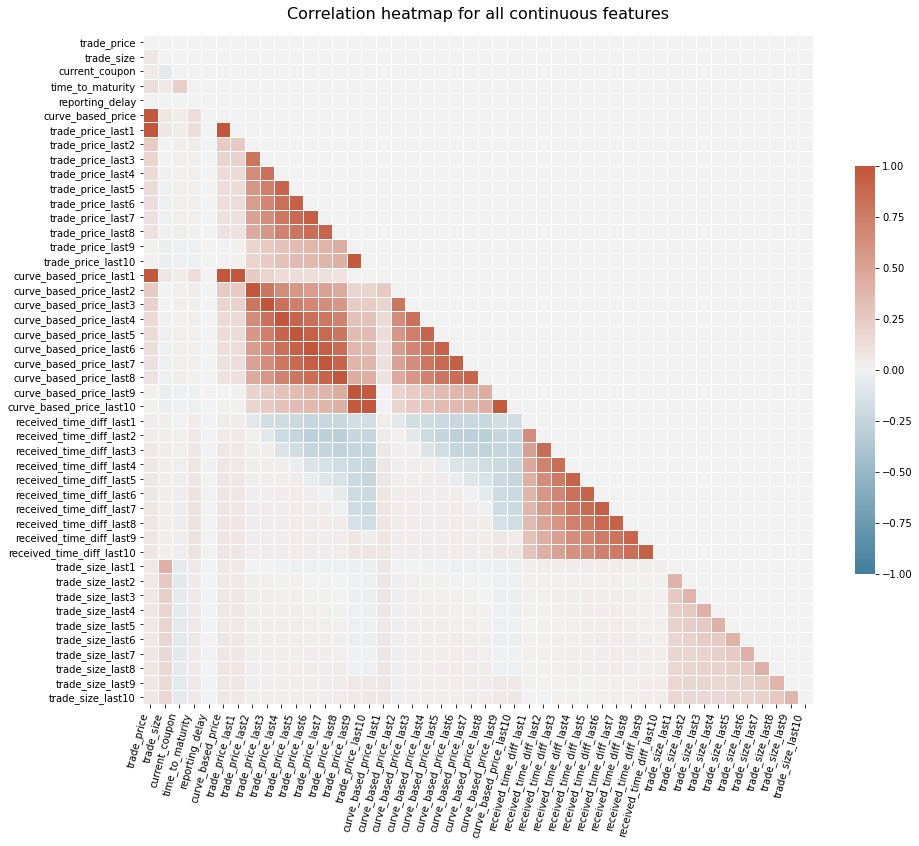

In [162]:
def plot_feature_corr(df):
    
    all_features = ["trade_price"] + get_cont_features()
    
    corr = fit_clean_data[all_features].corr()
    mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
    # only plot lower half
    corr = corr.where(mask, 0)
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    current_cmap = sns.diverging_palette(230, 20, as_cmap=True)
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=current_cmap,
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}
    )
    
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=75,
        horizontalalignment='right'
    )
    
    ax.set_facecolor('white')
    ax.set_title("Correlation heatmap for all continuous features", fontdict={"fontsize": 16}, pad=16)
    
plot_feature_corr(fit_clean_data)

### Dropping Historical Trades <a id="drop_historical_trades"></a>

The heatmap above shows how quickly information decays. *trade_price* is very correlated with *trade_price_last1*, but much less so with *trade_price_last2*. Removing trade features that contain little information will make our model training more robust.

In [271]:
def run_drop_historical_trades(model_init, baseline, fit_df, eval_df):
    
    results = {"fit": [], "eval": []}
    lags = [i for i in range(10,0, -1)]

    for max_lag in lags:
        model = model_init(baseline=baseline, max_lag=max_lag)
        model.fit(fit_df, eval_df)
        results["fit"].append(model.score(fit_df))
        results["eval"].append(model.score(eval_df))
        print("-------------")

    index = pd.Index(lags)
    index.name = "max_lag"
    display(pd.DataFrame(results, index=index).transpose())

In [272]:
run_drop_historical_trades(LinearReg, None, fit_clean_data, eval_clean_data)

Model created with 78 features: 33 discrete, 45 continuous. max_lag=10
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.22 seconds
-------------
Model created with 71 features: 30 discrete, 41 continuous. max_lag=9
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.14 seconds
-------------
Model created with 64 features: 27 discrete, 37 continuous. max_lag=8
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.10 seconds
-------------
Model created with 57 features: 24 discrete, 33 continuous. max_lag=7
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.08 seconds
-------------
Model created with 50 features: 21 discrete, 29 continuous. max_lag=6
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.07 seconds
-------------
Model created with 43 features: 18 discrete, 25 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.07 seconds
-------------
Model created with 36

max_lag,10,9,8,7,6,5,4,3,2,1
fit,0.872253,0.874461,0.876657,0.879857,0.882215,0.887413,0.895098,0.903438,0.926139,0.944095
eval,0.943616,0.945588,0.946734,0.949950,0.951171,0.953471,0.958874,0.963370,0.954844,0.977167


In [273]:
run_drop_historical_trades(Lasso, "curve_based_price", fit_clean_data, eval_clean_data)

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 1.24 seconds
-------------
Model created with 70 features: 30 discrete, 40 continuous. max_lag=9
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 1.25 seconds
-------------
Model created with 63 features: 27 discrete, 36 continuous. max_lag=8
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 1.09 seconds
-------------
Model created with 56 features: 24 discrete, 32 continuous. max_lag=7
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.88 seconds
-------------
Model created with 49 features: 21 discrete, 28 continuous. max_lag=6
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.87 seconds
-------------
Model created with 42 features: 18 discrete, 24 continuous. max_lag=5
Predicting: tr

max_lag,10,9,8,7,6,5,4,3,2,1
fit,0.98807,0.988058,0.988019,0.988213,0.988342,0.988524,0.988731,0.988214,0.986771,0.987049
eval,1.00616,1.006054,1.005673,1.005826,1.005766,1.005822,1.006353,1.005906,1.002384,1.002505


In [345]:
r_forest = RandomForest(baseline="curve_based_price", max_lag=5)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 48 features: 24 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 478.08 seconds
fit_clean: WMAE = 1.053
eval_clean: WMAE = 1.092


In [166]:
run_drop_historical_trades(BoostedTrees, "curve_based_price", fit_clean_data, eval_clean_data)

Model created with 78 features: 34 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 67.59 seconds
Epochs: 200, eval MAE: 0.991491
-------------
Model created with 71 features: 31 discrete, 40 continuous. max_lag=9
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 61.42 seconds
Epochs: 200, eval MAE: 0.991959
-------------
Model created with 64 features: 28 discrete, 36 continuous. max_lag=8
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 55.10 seconds
Epochs: 200, eval MAE: 0.981263
-------------
Model created with 57 features: 25 discrete, 32 continuous. max_lag=7
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 48.88 seconds
Epochs: 200, eval MAE: 0.985647
-------------
Model created with 50 features: 22 discrete, 28 continuous. max_lag=6
Predicting: trade_price - curve_based_price 

Running Model fit p

max_lag,10,9,8,7,6,5,4,3,2,1
fit,0.818710,0.821336,0.813942,0.814852,0.817894,0.820202,0.827005,0.822126,0.831568,0.835513
eval,0.991506,0.991974,0.981277,0.985665,0.988927,0.988277,0.987561,0.978373,0.977010,0.985275


In [167]:
run_drop_historical_trades(NeuralNet, "curve_based_price", fit_clean_data, eval_clean_data)

Model created with 77 features: 33 discrete, 44 continuous. max_lag=10
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 17.09 seconds
Epochs: 1500, fit MAE: 0.8512406945228577
-------------
Model created with 70 features: 30 discrete, 40 continuous. max_lag=9
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 15.47 seconds
Epochs: 1500, fit MAE: 0.8504359126091003
-------------
Model created with 63 features: 27 discrete, 36 continuous. max_lag=8
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 13.97 seconds
Epochs: 1500, fit MAE: 0.8413398861885071
-------------
Model created with 56 features: 24 discrete, 32 continuous. max_lag=7
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 13.44 seconds
Epochs: 1500, fit MAE: 0.8432527780532837
-------------
Model created with 49 features: 21 discrete, 28 continuous. max_lag=6
Predicting: trade_price -

max_lag,10,9,8,7,6,5,4,3,2,1
fit,0.823657,0.824918,0.817496,0.817783,0.809006,0.804207,0.814401,0.818809,0.858202,0.869926
eval,0.923419,0.915920,0.912889,0.908812,0.915022,0.903173,0.898029,0.906387,0.909592,0.936420


It appears that this does indeed tend to increase most model's performance. From now on we will retain history up to and including lag 5, mindful that we don't want to drop too much information too early. The table below illustrates the new scores.


| Test Set / <br /> Model  | Fit | Eval |
| :--- | :---: | :---: |
| **Baseline** | 1.141 | 1.169 | 
| **LinearReg** <br /> [raw predictee / max_lag=5]| 0.887 | 0.953 | 
| **Lasso** <br /> [relative predictee / max_lag=5]| 0.989 | 1.001 | 
| **RandForest** <br /> [relative predictee / max_lag=5]| 1.053 | 1.092 | 
| **BoostedTree** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*]| 0.820 | 0.988 | 
| **NeuralNet** <br /> [relative predictee / max_lag=5]| 0.804 | 0.903 | 


### In-built Feature Importance <a id="feature_importance"></a>

Some models have in-built methods to quantify the importance they attribute to each feature. Below we look at some of these to gain an insight into what the models deem most valuable.

Model created with 43 features: 18 discrete, 25 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.13 seconds
fit_clean: WMAE = 0.887
eval_clean: WMAE = 0.953


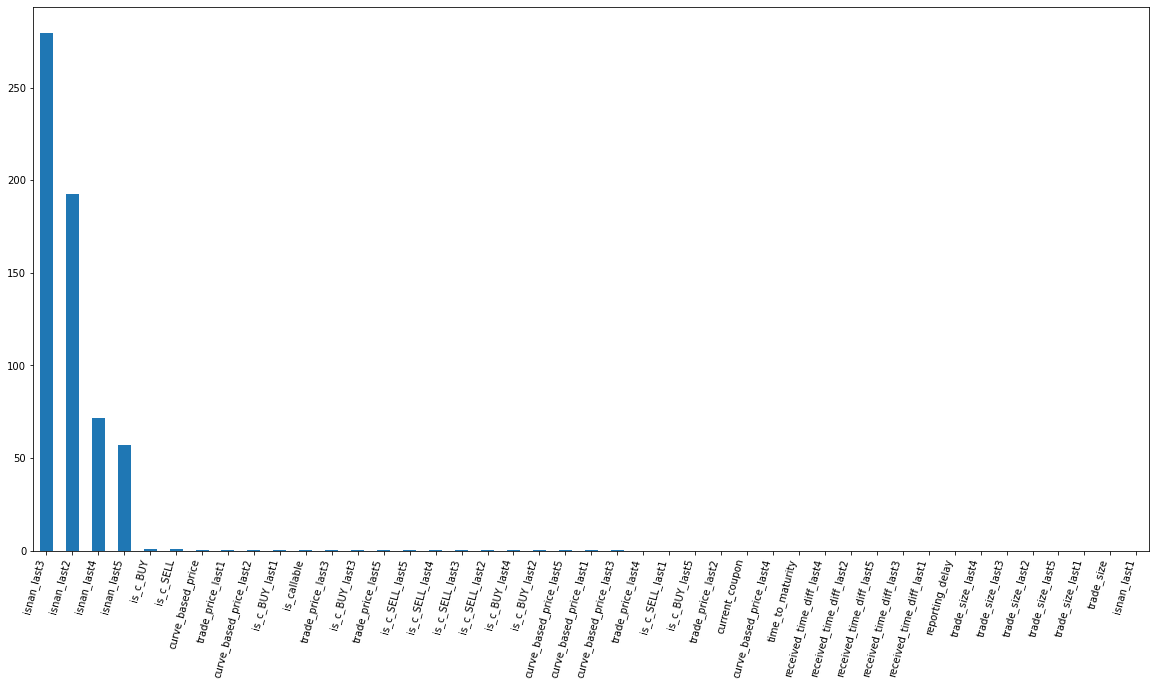

In [340]:
linear_reg = LinearReg(max_lag=5)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
linear_reg.plot_feature_importance()
del linear_reg

Model created with 42 features: 18 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.79 seconds
fit_clean: WMAE = 0.989
eval_clean: WMAE = 1.006


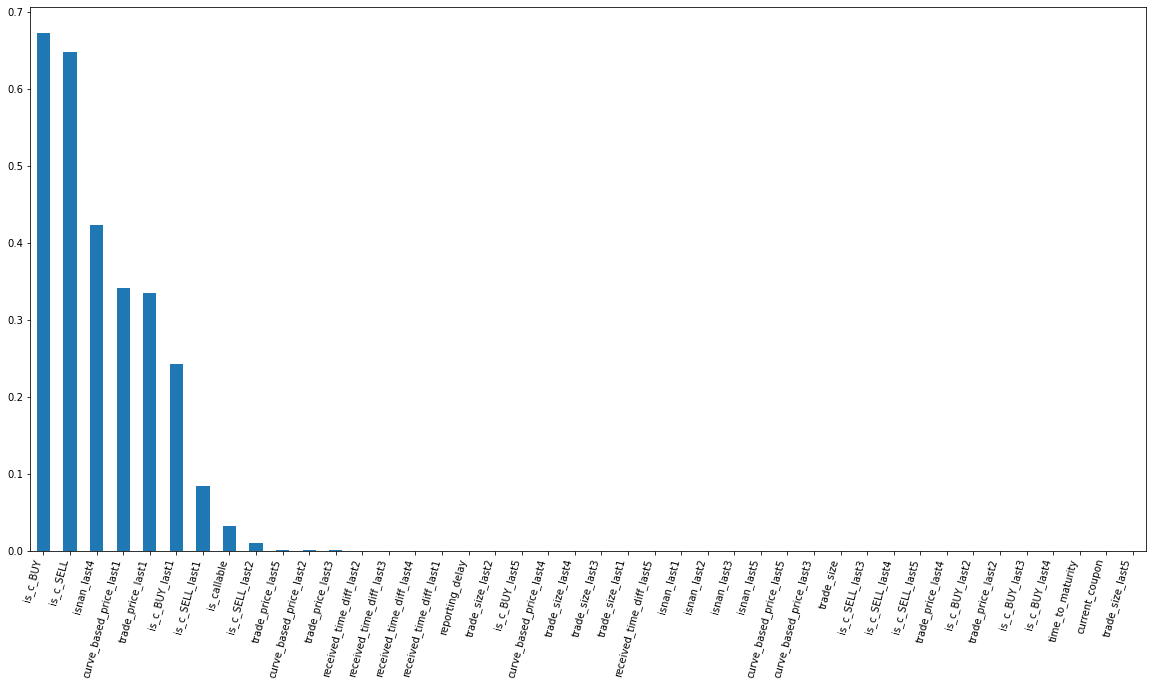

In [275]:
lasso = Lasso(baseline="curve_based_price", max_lag=5)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
lasso.plot_feature_importance()
del lasso

Model created with 48 features: 24 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 474.11 seconds
fit_clean: WMAE = 1.053
eval_clean: WMAE = 1.092


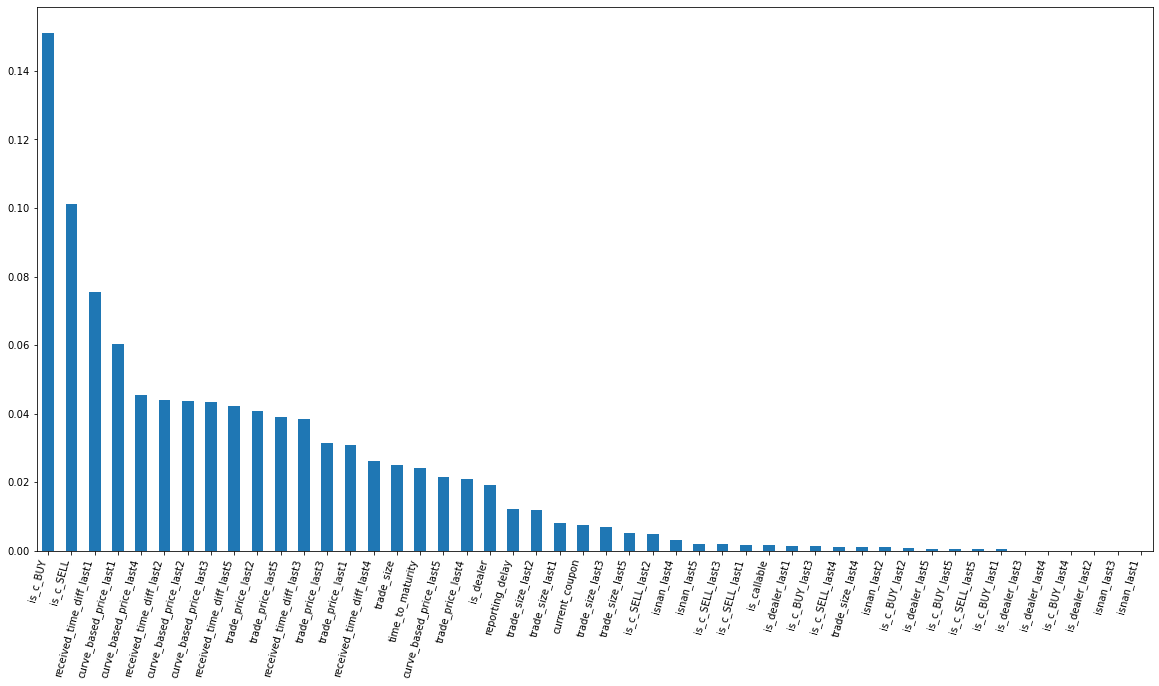

In [174]:
r_forest = RandomForest(baseline="curve_based_price", max_lag=5)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
r_forest.plot_feature_importance()
del r_forest

Model created with 43 features: 19 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 35.82 seconds
Epochs: 200, eval MAE: 0.988263
fit_clean: WMAE = 0.820
eval_clean: WMAE = 0.988


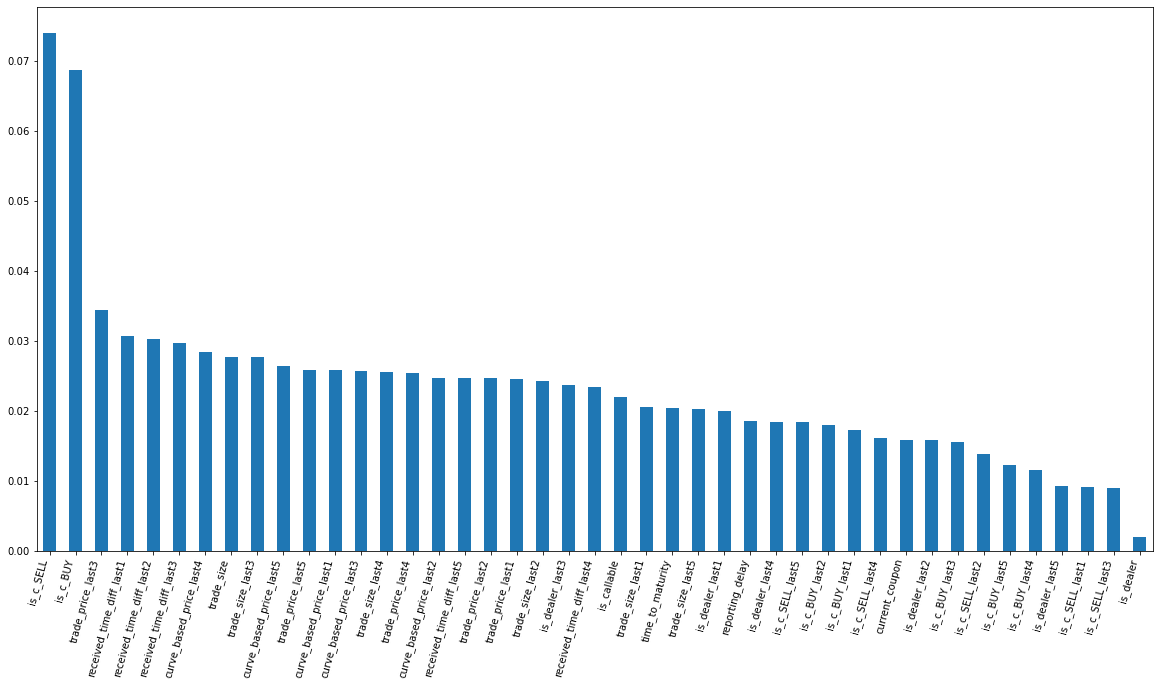

In [186]:
btree = BoostedTrees(baseline="curve_based_price", max_lag=5)
btree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {btree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {btree.score(eval_clean_data):.3f}")
btree.plot_feature_importance()
del btree

The LinearRegression results seem pretty nonsensical, whereas Lasso seems to sensibly put a lot of weight on the side of the current trade as well as information about the previous trade. RandomForest and BoostedTrees seem to have similar primary allocations to Lasso but contain a much longer-tail of non-zero weights. This is caused by the L1-regularisation term in Lasso that effectively acts like an in-built feature selector.

Note that these all use bespoke feature importance methods specific to each model. There are other model-agnostic and typically more robust methods such as *LIME* or *shap*.

### PCA Dimensionality Reduction <a id="pca"></a>

PCA might help us to engineer a set of reduced pseudo-features from the vast array of raw features - a form of automatic feature engineering.

PCA created with 25 continous features


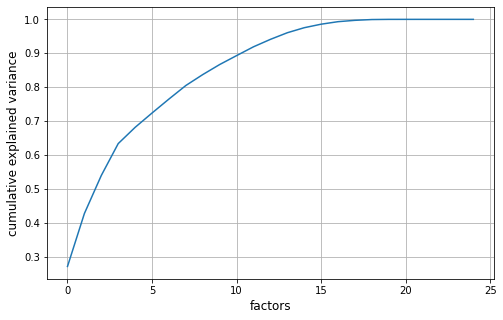

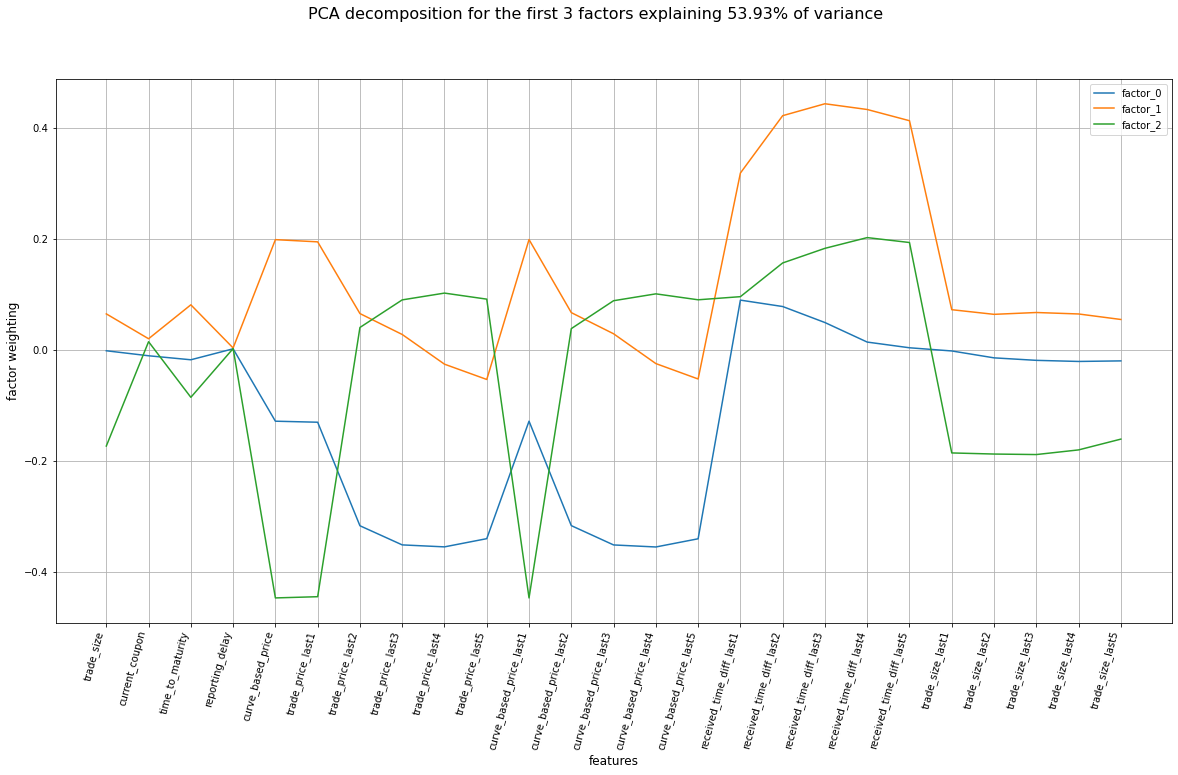

In [188]:
def compute_plot_pca(df, num_factors, max_lag:int=10):
    
    pca = pca_wrapper(num_factors=num_factors, max_lag=max_lag)
    pca.fit(df)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    cum_var = np.cumsum(pca.get_explained_var())
    plt.plot(cum_var)
    plt.xlabel("factors", fontsize=12)
    plt.ylabel("cumulative explained variance", fontsize=12)
    plt.grid()
    
    factors_df = pca.get_decomp()
    ax = factors_df.plot(figsize=(20,10))
    
    plt.xticks([i for i in range(len(pca.pca_features))], pca.pca_features)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=75,
        horizontalalignment='right'
    )
    
    plt.xlabel("features", fontsize=12)
    plt.ylabel("factor weighting", fontsize=12)
    plt.suptitle(f"PCA decomposition for the first {num_factors} factors explaining " + \
                 f"{cum_var[num_factors-1]*100:.2f}% of variance", fontsize=16)
    plt.grid()
    
compute_plot_pca(fit_clean_data, num_factors=3, max_lag=5)

The first plot shows that 90% of the variance in the 25 continuous features is captured by just 10 pseudo-features, generated as linear combinations of the raw features.

The second plot shows the individual feature weightings for the first 3 factors. These can be roughly grouped as:

**factor_0**: *trade_price_last{2-5}*, *curve_based_price_last{2-5}*<br>
**factor_1**: *received_time_diff_last{1-5}*<br>
**factor_2**: *curve_based_price* / *trade_size* / *trade_price_last1* / *curve_based_price_last1* / *trade_size_last{1-5}*<br>

Note that *current_coupon* / *time_to_maturity* / *reporting_delay* are essentially dropped by these first three factors.

Lets first replace all 25 continuous features with the first 10 PCA features:

In [276]:
pca_args = {"num_factors": 10}
linear_reg = LinearReg(pca_args=pca_args, max_lag=5)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

PCA created with 25 continous features
Model created with 28 features: 18 discrete, 10 continuous [10 PCA]. max_lag=5
Predicting: trade_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 0.16 seconds
fit_clean: WMAE = 0.965
eval_clean: WMAE = 1.009


In [277]:
pca_args = {"num_factors": 10}
lasso = Lasso(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

PCA created with 24 continous features
Model created with 28 features: 18 discrete, 10 continuous [10 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 0.25 seconds
fit_clean: WMAE = 1.102
eval_clean: WMAE = 1.110


In [343]:
pca_args = {"num_factors": 10}
r_forest = RandomForest(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

PCA created with 24 continous features
Model created with 34 features: 24 discrete, 10 continuous [10 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 397.57 seconds
fit_clean: WMAE = 1.065
eval_clean: WMAE = 1.095


In [212]:
pca_args = {"num_factors": 10}
btree = BoostedTrees(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
btree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {btree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {btree.score(eval_clean_data):.3f}")
del btree

PCA created with 24 continous features
Model created with 29 features: 19 discrete, 10 continuous [10 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 15.52 seconds
Epochs: 181, eval WMAE: 1.072129
fit_clean: WMAE = 0.948
eval_clean: WMAE = 1.072


In [213]:
pca_args = {"num_factors": 10}
nn = NeuralNet(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

PCA created with 24 continous features
Model created with 28 features: 18 discrete, 10 continuous [10 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 9.43 seconds
Epochs: 1500, fit WMAE: 1.0262585878372192
fit_clean: WMAE = 0.994
eval_clean: WMAE = 1.085


Every model has performed worse using this transformation.
Lets instead try using just the first 3 PCA factors, with the three low-weighted features (*current_coupon* / *time_to_maturity* / *reporting_delay*) explicitly held-out.

In [281]:
pca_args = {"num_factors": 3, "holdout_cols": ["current_coupon", "time_to_maturity", "reporting_delay"]}
linear_reg = LinearReg(pca_args=pca_args, max_lag=5)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

PCA created with 22 continous features
Model created with 24 features: 18 discrete, 6 continuous [3 PCA]. max_lag=5
Predicting: trade_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 0.13 seconds
fit_clean: WMAE = 1.453
eval_clean: WMAE = 1.489


In [197]:
pca_args = {"num_factors": 3, "holdout_cols": ["current_coupon", "time_to_maturity", "reporting_delay"]}
lasso = Lasso(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

PCA created with 21 continous features
Model created with 24 features: 18 discrete, 6 continuous [3 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 0.19 seconds
fit_clean: WMAE = 1.102
eval_clean: WMAE = 1.111


In [344]:
pca_args = {"num_factors": 3, "holdout_cols": ["current_coupon", "time_to_maturity", "reporting_delay"]}
r_forest = RandomForest(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

PCA created with 21 continous features
Model created with 30 features: 24 discrete, 6 continuous [3 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 325.82 seconds
fit_clean: WMAE = 1.064
eval_clean: WMAE = 1.090


In [214]:
pca_args = {"num_factors": 3, "holdout_cols": ["current_coupon", "time_to_maturity", "reporting_delay"]}
btree = BoostedTrees(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
btree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {btree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {btree.score(eval_clean_data):.3f}")
del btree

PCA created with 21 continous features
Model created with 25 features: 19 discrete, 6 continuous [3 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 13.89 seconds
Epochs: 200, eval WMAE: 1.048323
fit_clean: WMAE = 0.903
eval_clean: WMAE = 1.048


In [215]:
pca_args = {"num_factors": 3, "holdout_cols": ["current_coupon", "time_to_maturity", "reporting_delay"]}
nn = NeuralNet(baseline="curve_based_price", pca_args=pca_args, max_lag=5)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

PCA created with 21 continous features
Model created with 24 features: 18 discrete, 6 continuous [3 PCA]. max_lag=5
Predicting: trade_price - curve_based_price 

Running PCA fit pipeline
Running Model fit pipeline
Fitting took 8.97 seconds
Epochs: 1500, fit WMAE: 1.0358695983886719
fit_clean: WMAE = 1.005
eval_clean: WMAE = 1.056


This still performs worse on the evaluation data than simply giving each model all 70 features. It looks like we won't be able to rely on automatic feature engineering and will have to try more bespoke techniques.

### Dropping Uninformative Features <a id="drop_features"></a>

The feature importance and PCA investigations above show that some features are clearly much more important than others. Dropping uninformative features can help to improve the robustness of our models.

#### Dropping discrete *isnan_last{1-5}*

We introduced these features to help the models identify trades with short histories, but perhaps they are simply adding noise? Note that these were never included in the BoostedTree model as it has an in-built way to handle missing values.

In [282]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False)

linear_reg = LinearReg(discrete_feat=discrete_features, max_lag=max_lag)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 38 features: 13 discrete, 25 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.08 seconds
fit_clean: WMAE = 0.900
eval_clean: WMAE = 0.926


In [283]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False)

lasso = Lasso(baseline="curve_based_price", discrete_feat=discrete_features, max_lag=max_lag)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.71 seconds
fit_clean: WMAE = 0.989
eval_clean: WMAE = 1.006


In [347]:
max_lag=5
discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False)

r_forest = RandomForest(baseline="curve_based_price", discrete_feat=discrete_features, max_lag=max_lag)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 43 features: 19 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 506.80 seconds
fit_clean: WMAE = 1.039
eval_clean: WMAE = 1.079


In [242]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False)

nn = NeuralNet(baseline="curve_based_price", discrete_feat=discrete_features, max_lag=max_lag)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.63 seconds
Epochs: 1500, fit WMAE: 0.8335510492324829
fit_clean: WMAE = 0.816
eval_clean: WMAE = 0.910


This seems to increase the LinearReg evaluation performance, which makes sense since its feature importance plot above shows it putting a lot of weight on these features. The new feature plot below is much more intuitive. It also improves the RandomForest score.

However, it seems that Lasso and NeuralNet were finding these features useful as their performance has decreased. <font color='red'>red</font> highlights the updated scores in the table below.

| Test Set / <br /> Model  | Fit | Eval |
| :--- | :---: | :---: |
| **Baseline** | 1.141 | 1.169 | 
| **LinearReg** <br /> [raw predictee / max_lag=5 <br /> drop *isnan*]| 0.900 | <font color='red'>0.926</font> | 
| **Lasso** <br /> [relative predictee / max_lag=5]| 0.989 | 1.001 | 
| **RandForest** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*]| 1.039 | <font color='red'>1.079</font> | 
| **BoostedTree** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*]| 0.820 | 0.988 | 
| **NeuralNet** <br /> [relative predictee / max_lag=5]| 0.804 | 0.903 | 

Model created with 38 features: 13 discrete, 25 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.13 seconds
fit_clean: WMAE = 0.900
eval_clean: WMAE = 0.926


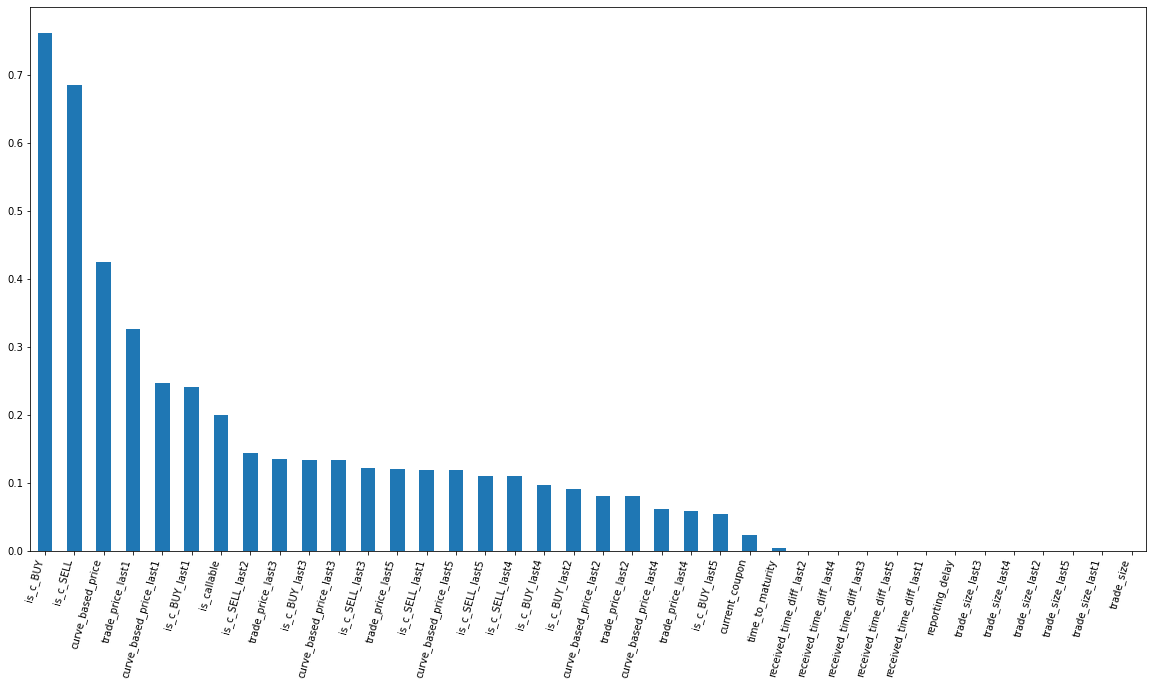

In [341]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False)

linear_reg = LinearReg(discrete_feat=discrete_features, max_lag=max_lag)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
linear_reg.plot_feature_importance()
del linear_reg

#### Dropping unused continuous features

The feature importance plots above hint that maybe the following continuous features don't contain that much information: *current_coupon*, *time_to_maturity*, *reporting_delay*, *trade_size*

Below we drop these one-by-one to see how performance changes.

In [300]:
def run_drop_cont_features(model_init, drop_cont_features, fit_df, eval_df, discrete_features=[], baseline=None):
    
    results = {"fit": [], "eval": []}
    max_lag=5

    for drop_feature in drop_cont_features:
        # Be sure to drop the baseline feature (if there is one)
        exclude_cols = [drop_feature, baseline]
        cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols)
        model = model_init(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features,
                           max_lag=max_lag)
        model.fit(fit_df, eval_df)
        results["fit"].append(model.score(fit_df))
        results["eval"].append(model.score(eval_df))
        print("-------------")

    index = pd.Index(drop_cont_features)
    index.name = "dropped_feature"
    display(pd.DataFrame(results, index=index).transpose())
    
drop_features = ["current_coupon", "time_to_maturity", "reporting_delay", "trade_size"]

In [301]:
discrete_features = get_discrete_features(encoding="dummy", max_lag=5, include_isnan=False)

run_drop_cont_features(LinearReg, drop_features, fit_clean_data, eval_clean_data, discrete_features=discrete_features)

Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.10 seconds
-------------
Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.05 seconds
-------------
Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.05 seconds
-------------
Model created with 37 features: 13 discrete, 24 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.05 seconds
-------------


dropped_feature,current_coupon,time_to_maturity,reporting_delay,trade_size
fit,0.899849,0.900608,0.900172,0.900128
eval,0.925611,0.926010,0.925207,0.926018


In [302]:
run_drop_cont_features(Lasso, drop_features, fit_clean_data, eval_clean_data, baseline="curve_based_price")

Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.75 seconds
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.71 seconds
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.66 seconds
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.66 seconds
-------------


dropped_feature,current_coupon,time_to_maturity,reporting_delay,trade_size
fit,0.988524,0.988524,0.988549,0.988524
eval,1.005822,1.005822,1.005502,1.005822


In [353]:
max_lag=5
baseline = "curve_based_price"

discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False)
cont_features = get_cont_features(max_lag=max_lag, exclude=[baseline, "reporting_delay"])

r_forest = RandomForest(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features,
                        max_lag=max_lag)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 42 features: 19 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 472.23 seconds
fit_clean: WMAE = 1.038
eval_clean: WMAE = 1.078


In [305]:
run_drop_cont_features(BoostedTrees, drop_features, fit_clean_data, eval_clean_data, baseline="curve_based_price")

Model created with 42 features: 19 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 35.70 seconds
Epochs: 200, eval WMAE: 0.99422
-------------
Model created with 42 features: 19 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 35.39 seconds
Epochs: 200, eval WMAE: 0.991288
-------------
Model created with 42 features: 19 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 35.70 seconds
Epochs: 200, eval WMAE: 0.985194
-------------
Model created with 42 features: 19 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 36.07 seconds
Epochs: 200, eval WMAE: 1.002263
-------------


dropped_feature,current_coupon,time_to_maturity,reporting_delay,trade_size
fit,0.814930,0.827193,0.816031,0.840784
eval,0.994236,0.991305,0.985211,1.002280


In [303]:
run_drop_cont_features(NeuralNet, drop_features, fit_clean_data, eval_clean_data, baseline="curve_based_price")

Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.50 seconds
Epochs: 1500, fit WMAE: 0.8520159721374512
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.45 seconds
Epochs: 1500, fit WMAE: 0.8609122037887573
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.24 seconds
Epochs: 1500, fit WMAE: 0.8518823385238647
-------------
Model created with 41 features: 18 discrete, 23 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.39 seconds
Epochs: 1500, fit WMAE: 0.8526237607002258
-------------


dropped_feature,current_coupon,time_to_maturity,reporting_delay,trade_size
fit,0.820791,0.841827,0.828866,0.827921
eval,0.914981,0.936297,0.922324,0.923448


LinearReg, RandForest and BoostedTree all marginally improve when *reporting_delay* is dropped. Lasso is totally unaffected since it places zero-weight on all of these features already. The NeuralNet performance decreases if any of these features are dropped.

| Test Set / <br /> Model  | Fit | Eval |
| :--- | :---: | :---: |
| **Baseline** | 1.141 | 1.169 | 
| **LinearReg** <br /> [raw predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay*]| 0.900 | <font color='red'>0.925</font> | 
| **Lasso** <br /> [relative predictee / max_lag=5]| 0.989 | 1.001 | 
| **RandForest** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay*]| 1.038 | <font color='red'>1.078</font> |
| **BoostedTree** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay*]| 0.816 | <font color='red'>0.985</font> | 
| **NeuralNet** <br /> [relative predictee / max_lag=5]| 0.804 | 0.903 | 

### Using Relative Price Features <a id="relative_prices"></a>

Earlier we showed that most models benefitted from predicting relative prices: [*trade_price - curve_based_price*]. They might also benefit from encoding each historical trade price as [*trade_price_lastn - curve_based_price_lastn*]. This reduces the number of features whilst preserving their information content.

In [334]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False)

exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay"]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

linear_reg = LinearReg(discrete_feat=discrete_features, cont_feat=cont_features, max_lag=max_lag)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 32 features: 13 discrete, 19 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.07 seconds
fit_clean: WMAE = 0.981
eval_clean: WMAE = 1.004


In [349]:
max_lag=5
baseline = "curve_based_price"
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

lasso = Lasso(baseline=baseline, cont_feat=cont_features, max_lag=max_lag)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.18 seconds
fit_clean: WMAE = 0.973
eval_clean: WMAE = 0.995


In [350]:
max_lag=5
baseline = "curve_based_price"

discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False)
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

r_forest = RandomForest(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features,
                        max_lag=max_lag)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 37 features: 19 discrete, 18 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 480.59 seconds
fit_clean: WMAE = 0.951
eval_clean: WMAE = 0.986


In [351]:
max_lag=5
baseline = "curve_based_price"
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

btree = BoostedTrees(baseline=baseline, cont_feat=cont_features, max_lag=max_lag)
btree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {btree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {btree.score(eval_clean_data):.3f}")
del btree

Model created with 37 features: 19 discrete, 18 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 29.39 seconds
Epochs: 200, eval WMAE: 0.890503
fit_clean: WMAE = 0.692
eval_clean: WMAE = 0.891


In [352]:
max_lag=5
baseline = "curve_based_price"
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

nn = NeuralNet(baseline=baseline, cont_feat=cont_features, max_lag=max_lag)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 10.56 seconds
Epochs: 1500, fit WMAE: 0.830065906047821
fit_clean: WMAE = 0.803
eval_clean: WMAE = 0.869


This seems to dramatically improve all models that already predicted relative price.


| Test Set / <br /> Model  | Fit | Eval |
| :--- | :---: | :---: |
| **Baseline** | 1.141 | 1.169 | 
| **LinearReg** <br /> [raw predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay*]| 0.900 | 0.925 | 
| **Lasso** <br /> [relative predictee / max_lag=5 <br /> relative price features]| 0.973 | <font color='red'>0.995</font> | 
| **RandForest** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay* <br /> relative price features]| 0.951 | <font color='red'>0.986</font> | 
| **BoostedTree** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay* <br /> relative price features]| 0.692 | <font color='red'>0.891</font> | 
| **NeuralNet** <br /> [relative predictee / max_lag=5 <br /> relative price features]| 0.803 | <font color='red'>0.869</font> | 

### Detecting Large Trades <a id="large_trades"></a>

Recall that in our exploratory analysis we discovered an unusual number of trades with size \\$1,000,001 and \\$5,000,001. We concluded that these are possibly placeholders (due to the reporting rules of TRACE) and might signify that the trade was actually much larger than this. We will see if any of the models can extract any information from the binary feature *is_large_trade*.

In [381]:
max_lag=5
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag, include_isnan=False) + ["is_large_trade"]
cont_features = get_cont_features(max_lag=max_lag, exclude=["reporting_delay"])

linear_reg = LinearReg(discrete_feat=discrete_features, cont_feat=cont_features, max_lag=max_lag)
linear_reg.fit(fit_clean_data)
print(f"fit_clean: WMAE = {linear_reg.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {linear_reg.score(eval_clean_data):.3f}")
del linear_reg

Model created with 38 features: 14 discrete, 24 continuous. max_lag=5
Predicting: trade_price 

Running Model fit pipeline
Fitting took 0.07 seconds
fit_clean: WMAE = 0.900
eval_clean: WMAE = 0.927


In [383]:
max_lag=5
baseline = "curve_based_price"
discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag) + ["is_large_trade"]
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

lasso = Lasso(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features, max_lag=max_lag)
lasso.fit(fit_clean_data)
print(f"fit_clean: WMAE = {lasso.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {lasso.score(eval_clean_data):.3f}")
del lasso

Model created with 38 features: 19 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.19 seconds
fit_clean: WMAE = 0.973
eval_clean: WMAE = 0.996


In [375]:
max_lag=5
baseline = "curve_based_price"

discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False)  + ["is_large_trade"]
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

r_forest = RandomForest(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features,
                        max_lag=max_lag)
r_forest.fit(fit_clean_data)
print(f"fit_clean: WMAE = {r_forest.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {r_forest.score(eval_clean_data):.3f}")
del r_forest

Model created with 38 features: 20 discrete, 18 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 485.88 seconds
fit_clean: WMAE = 0.947
eval_clean: WMAE = 0.984


In [386]:
max_lag=5
baseline = "curve_based_price"

discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False) + ["is_large_trade"]
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

btree = BoostedTrees(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features, max_lag=max_lag)
btree.fit(fit_clean_data, eval_clean_data)
print(f"fit_clean: WMAE = {btree.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {btree.score(eval_clean_data):.3f}")
del btree

Model created with 38 features: 20 discrete, 18 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 29.82 seconds
Epochs: 200, eval WMAE: 0.891773
fit_clean: WMAE = 0.692
eval_clean: WMAE = 0.892


In [387]:
max_lag=5
baseline = "curve_based_price"

discrete_features = get_discrete_features(encoding="dummy", max_lag=max_lag) + ["is_large_trade"]
exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

nn = NeuralNet(baseline=baseline, discrete_feat=discrete_features, cont_feat=cont_features, max_lag=max_lag)
nn.fit(fit_clean_data)
print(f"fit_clean: WMAE = {nn.score(fit_clean_data):.3f}")
print(f"eval_clean: WMAE = {nn.score(eval_clean_data):.3f}")
del nn

Model created with 38 features: 19 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.05 seconds
Epochs: 1500, fit WMAE: 0.8464419841766357
fit_clean: WMAE = 0.828
eval_clean: WMAE = 0.905


All models perform worse with this feature, apart from RandForest.

| Test Set / <br /> Model  | Fit | Eval |
| :--- | :---: | :---: |
| **Baseline** | 1.141 | 1.169 | 
| **LinearReg** <br /> [raw predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay*]| 0.900 | 0.925 | 
| **Lasso** <br /> [relative predictee / max_lag=5 <br /> relative price features]| 0.973 | 0.995 | 
| **RandForest** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay* <br /> relative price features <br /> use *is_large_trade*]| 0.947 | <font color='red'>0.984</font> | 
| **BoostedTree** <br /> [relative predictee / max_lag=5 <br /> drop *isnan*, *reporting_delay* <br /> relative price features]| 0.692 | 0.891 | 
| **NeuralNet** <br /> [relative predictee / max_lag=5 <br /> relative price features]| 0.803 | 0.869 | 

## Hyper-parameter Tuning <a id="hyper_tuning"></a>

We deliberately held out an evaluation data set for hyper-parameter tuning - this is equivalent to a 1-fold cross-validation. To more aggressively control overfitting one should really disect the data further and do a $k$-fold cross-validation.

### Lasso <a id="lasso"></a>

Lasso is a very simple model and only has one hyper-parameter, *alpha*, which corresponds to the L1 regularisation weight. It seems like the optimal value is around 0.001.

In [391]:
def run_tune_lasso(fit_df, eval_df, alphas):
    
    max_lag=5
    baseline = "curve_based_price"
    exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
    cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]
    
    results = {"fit": [], "eval": []}
    for alpha in alphas:
        lasso = Lasso(baseline=baseline, cont_feat=cont_features, max_lag=max_lag, alpha=alpha)
        lasso.fit(fit_clean_data)
        results["fit"].append(lasso.score(fit_clean_data))
        results["eval"].append(lasso.score(eval_clean_data))
        print("-------------")

    index = pd.Index(alphas)
    index.name = "alpha"
    display(pd.DataFrame(results, index=index).transpose())
    
run_tune_lasso(fit_clean_data, eval_clean_data, [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline


/Users/cous/miniforge3/envs/conda-venv-3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55217.786391393434, tolerance: 18.754681008521114
  model = cd_fast.enet_coordinate_descent(


Fitting took 13.65 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline


/Users/cous/miniforge3/envs/conda-venv-3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21197.14730031918, tolerance: 18.754681008521114
  model = cd_fast.enet_coordinate_descent(


Fitting took 14.44 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.19 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.08 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.04 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.05 seconds
-------------
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 0.04 seconds
-------------


alpha,0.000001,0.000010,0.000100,0.001000,0.010000,0.100000,1.000000
fit,0.954988,0.960824,0.973476,0.970339,1.140432,1.140432,1.140432
eval,0.971836,0.981897,0.995407,0.993954,1.168892,1.168892,1.168892


### RandomForest <a id="random_forest"></a>

This model appears to become better as we feed more data, *max_samples*, allow greater complexity, *max_depth*, and average over a larger ensemble, *n_estimators*.

In [16]:
def run_tune_randforest(fit_df, eval_df, param_names, params):
    
    param_combinations = list(itertools.product(*params))
    param_dicts = [dict(zip(param_names, list(combin))) for combin in param_combinations]

    max_lag=5
    baseline = "curve_based_price"
    discrete_features = get_discrete_features(encoding="one-hot", max_lag=max_lag, include_isnan=False) + ["is_large_trade"]
    exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
    cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

    results = {"fit": [], "eval": []}
    index = []
    i = 1
    for param_dict in param_dicts:
        print(f"Fitting {i}/{len(param_dicts)}: {param_dict}")
        r_forest = RandomForest(**param_dict, baseline=baseline, discrete_feat=discrete_features, 
                                cont_feat=cont_features, max_lag=max_lag)
        r_forest.fit(fit_df)
        results["fit"].append(r_forest.score(fit_df))
        results["eval"].append(r_forest.score(eval_df))
        index.append("/".join([str(param_dict[param]) for param in param_names]))
        del r_forest
        print("-------------")
        i += 1

    index = pd.Index(index)
    index_name = "/".join(param_names)
    index.name = index_name
    results_df = pd.DataFrame(results, index=index).sort_values("eval")
    results_df.to_csv("data/randforest_hyperparameters.csv")
    results_df = load_data("randforest_hyperparameters", index_name=index_name)
    display(results_df.style.background_gradient(cmap='inferno_r', subset = ["eval"]))

In [17]:
param_names = ["max_samples", "max_features", "n_estimators", "max_depth"]
params = [[0.2, 0.5, 0.8], ["auto", "sqrt"], [30, 50], [5, 7, 9]]

run_tune_randforest(fit_clean_data, eval_clean_data, param_names, params)

,fit,eval
max_samples/max_features/n_estimators/max_depth,,
0.8/auto/50/9,0.708465,0.888466
0.2/auto/30/9,0.808010,0.890282
0.2/auto/50/9,0.802996,0.890665
0.5/auto/50/9,0.738606,0.891529
0.8/auto/30/9,0.712785,0.892063
0.5/auto/30/9,0.739549,0.892773
0.8/sqrt/30/9,0.762428,0.892915
0.8/sqrt/50/9,0.759356,0.893838
0.8/auto/50/7,0.778092,0.897721


### BoostedTrees <a id="boosted_trees"></a>

This model also appears to become better as we feed more data, *subsample*, allow greater complexity, *max_depth*, and average over a larger ensemble, *n_estimators*.

In [20]:
def run_tune_boostedtree(fit_df, eval_df, param_names, params):
    
    param_combinations = list(itertools.product(*params))
    param_dicts = [dict(zip(param_names, list(combin))) for combin in param_combinations]

    max_lag=5
    baseline = "curve_based_price"
    exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + ["reporting_delay", baseline]
    cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

    results = {"fit": [], "eval": []}
    index = []
    i = 1
    for param_dict in param_dicts:
        print(f"Fitting {i}/{len(param_dicts)}: {param_dict}")
        btree = BoostedTrees(**param_dict, baseline=baseline, cont_feat=cont_features, max_lag=max_lag)
        btree.fit(fit_df, eval_df)
        results["fit"].append(btree.score(fit_df))
        results["eval"].append(btree.score(eval_df))
        index.append("/".join([str(param_dict[param]) for param in param_names]))
        del btree
        print("-------------")
        i += 1

    index = pd.Index(index)
    index_name = "/".join(param_names)
    index.name = index_name
    results_df = pd.DataFrame(results, index=index).sort_values("eval")
    results_df.to_csv("data/boostedtree_hyperparameters.csv")
    results_df = load_data("boostedtree_hyperparameters", index_name=index_name)
    display(results_df.style.background_gradient(cmap='inferno_r', subset = ["eval"]))

In [21]:
param_names = ["subsample", "colsample_bytree", "n_estimators", "max_depth", "learning_rate"]
params = [[0.5, 0.8], [0.5, 0.8, 1], [100, 200, 300, 400], [3, 5, 7, 9], [0.01, 0.001]]

run_tune_boostedtree(fit_clean_data, eval_clean_data, param_names, params)

,fit,eval
subsample/colsample_bytree/n_estimators/max_depth/learning_rate,,
0.8/1/400/9/0.01,0.376950,0.853486
0.8/0.5/400/9/0.01,0.383038,0.854781
0.8/0.8/400/9/0.01,0.380170,0.855113
0.8/1/300/9/0.01,0.407949,0.856659
0.8/1/400/7/0.01,0.502075,0.856907
0.5/0.5/400/9/0.01,0.468167,0.857837
0.8/0.8/400/7/0.01,0.513457,0.858462
0.8/0.8/300/9/0.01,0.415151,0.858472
0.8/0.5/300/9/0.01,0.428301,0.859004


### NeuralNet <a id="neural_net"></a>

In [38]:
def run_tune_neuralnet(fit_df, eval_df, param_names, params):
    
    param_combinations = list(itertools.product(*params))
    param_dicts = [dict(zip(param_names, list(combin))) for combin in param_combinations]
    
    max_lag=5
    baseline = "curve_based_price"
    exclude_cols = [f"{x}{i}" for x in ["trade_price_last", "curve_based_price_last"] for i in range(1,max_lag+1)] + [baseline]
    cont_features = get_cont_features(max_lag=max_lag, exclude=exclude_cols) + [f"trade_minus_curve_price_last{i}" for i in range(1,max_lag+1)]

    results = {"fit": [], "eval": []}
    index = []
    i = 1
    for param_dict in param_dicts:
        print(f"Fitting {i}/{len(param_dicts)}: {param_dict}")
        nn = NeuralNet(**param_dict, baseline=baseline, cont_feat=cont_features, max_lag=max_lag)
        nn.fit(fit_df)
        results["fit"].append(nn.score(fit_df))
        results["eval"].append(nn.score(eval_df))
        index.append("/".join([str(param_dict[param]) for param in param_names]))
        del nn
        print("-------------")
        i += 1

    index = pd.Index(index)
    index_name = "/".join(param_names)
    index.name = index_name
    results_df = pd.DataFrame(results, index=index).sort_values("eval")
    results_df.to_csv("data/neuralnet_hyperparameters.csv")
    results_df = load_data("neuralnet_hyperparameters", index_name=index_name)
    display(results_df.style.background_gradient(cmap='inferno_r', subset = ["eval"]))

In [ ]:
param_names = ["subsample", "dropout_rate", "hidden_nodes", "epochs", "learning_rate"]
params = [[0.5, 0.8], [0, 0.05, 0.1], [15, 40, 80], [1500, 3000], [0.01, 0.001]]

run_tune_neuralnet(fit_clean_data, eval_clean_data, param_names, params)

Fitting 1/72: {'subsample': 0.5, 'dropout_rate': 0, 'hidden_nodes': 15, 'epochs': 1500, 'learning_rate': 0.01}
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 12.05 seconds
Epochs: 1500, fit WMAE: 0.830065906047821
-------------
Fitting 2/72: {'subsample': 0.5, 'dropout_rate': 0, 'hidden_nodes': 15, 'epochs': 1500, 'learning_rate': 0.001}
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 11.69 seconds
Epochs: 1500, fit WMAE: 0.9479199051856995
-------------
Fitting 3/72: {'subsample': 0.5, 'dropout_rate': 0, 'hidden_nodes': 15, 'epochs': 3000, 'learning_rate': 0.01}
Model created with 37 features: 18 discrete, 19 continuous. max_lag=5
Predicting: trade_price - curve_based_price 

Running Model fit pipeline
Fitting took 22.96 seconds
Epochs: 3000, fit WMAE: 0.8168211579322815


## Further Work <a id="further_work"></a>

Whilst it looks like NeuralNet is probably the best model, I need to finalise the hyper-parameter tuning and finally compare test set performance across each model. Finally, I should actually backtest these models under some hit-rate assumptions and see which maximises bid/offer revenue.

Lastly, a few remaining ideas for model improvements include:

- try a pure price/time model like a Kalman Filter
- PCA was poor at encoding information into a reduced set of linear pseudo-features, perhaps try an Autoencoder that allows us to learn non-linear combinations